In [1]:
import os
import sys
from pathlib import Path
from importlib import reload
import warnings
os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd
from sqlalchemy import create_engine
import libpysal as lps
from esda import smoothing as sm
from libpysal.weights.distance import get_points_array
from scipy.spatial import cKDTree
from spreg import OLS
from esda import fdr
import spreg
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
from sklearn.cluster import AgglomerativeClustering

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point, Polygon
from matplotlib import patches, colors
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from PIL import ImageColor
import matplotlib_inline.backend_inline
import pydotplus
import plotly.express as px
import pickle
from generativepy.color import Color
from geoalchemy2 import Geometry, WKTElement
import contextily as ctx
from six import StringIO
from tableone import TableOne
from statannotations.Annotator import Annotator

sys.path.append('/Users/david/Dropbox/PhD/Scripts/Spatial analyses')
import pyspace
from utils import *
engine = create_engine('postgresql://postgres@localhost:5432/david')
# Set pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Ignore this specific UserWarning
warnings.filterwarnings("ignore", category=UserWarning, message="The weights matrix is not fully connected")
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Set matplotlib display format
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%matplotlib inline

## Import data

In [2]:
# Participation data
df_participation = pd.read_feather('../Data/Processed data/20230627_GIRACS_all.feather')

# Make gdf
# geometry = [Point(xy) for xy in zip(df_participation.e, df_participation.n)]
crs = 'epsg:2056'
gdf_participation = gpd.GeoDataFrame(df_participation, crs=crs, geometry=gpd.points_from_xy(df_participation.E, df_participation.N))

In [3]:
print('Number of invitations :', gdf_participation.shape[0])
print('Number of women :', gdf_participation.numerodossier.nunique())

Number of invitations : 579033
Number of women : 134814


In [4]:
# Administrative boundaries
lake = gpd.read_file('/Users/david/Dropbox/PhD/GitHub/COVID19/Data/Mapping/lake.geojson')
lake.NOM = ['Lake Geneva', '', '']
cantons = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
communes = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp')
# Only retain communes that are in the canton of Geneva
communes = communes[communes.KANTONSNUM == 25]

cantons = cantons.to_crs(2056)
communes = communes.to_crs(2056)

### Specchio data

In [5]:
gdf_specchio = gpd.read_file('/Users/david/Dropbox/PhD/GitHub/GIRACS/Data/Specchio Data/participants_geneve.gpkg')
df_specchio = pd.read_csv('/Users/david/Dropbox/PhD/GitHub/GIRACS/Data/Specchio Data/ALL_inc.csv', sep=',', low_memory = False)

In [6]:
df_specchio = df_specchio[df_specchio[['serocov_pop', 'sp3_juin_2021', 'sp2_novdec_2020', 'sp4_avril_2022']].any(axis = 1)]
df_specchio_mammo = df_specchio.filter(regex=r'mammo|codbar_x|X|Y|\bsex\b|age_at_Q_submission|GIREC')
df_specchio_mammo = df_specchio_mammo.rename(columns = {"codbar_x":'codbar'})
df_specchio_mammo = df_specchio_mammo[(df_specchio_mammo.sex == 'Femme')&(df_specchio_mammo.age_at_Q_submission.between(50,74))]
gdf_specchio_mammo = gpd.GeoDataFrame(df_specchio_mammo, crs = 2056, geometry = gpd.points_from_xy(df_specchio_mammo.X, df_specchio_mammo.Y))

## Simples visualizations

In [7]:
# changed_behavior_positive = df_participation[df_participation.mammo_last_invite ==1]
# changed_behavior_negative = df_participation[df_participation.mammo_last_invite ==-1]
# stable_behavior_positive = df_participation[(df_participation.mammo_last_invite ==0)& (df_participation.mammo == 1)]
# stable_behavior_negative = df_participation[(df_participation.mammo_last_invite ==0)& (df_participation.mammo == 0)]

Text(0, 0.5, 'Invitation count')

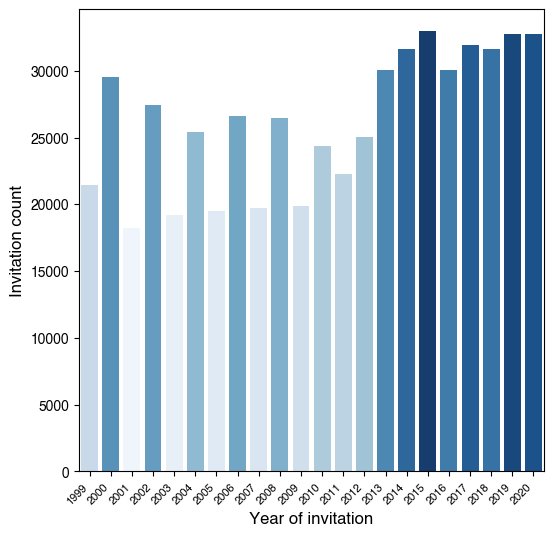

In [8]:
n_invit_by_year = pd.DataFrame(df_participation.groupby('year_invit').size()).reset_index()
pal = sns.color_palette("Blues", len(n_invit_by_year))
rank = n_invit_by_year[0].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
chart = sns.barplot(x="year_invit", y=0, data=n_invit_by_year, palette = np.array(pal)[rank], ax = ax)
chart.set_xticklabels(chart.get_xticklabels(),size = 8, rotation=45, horizontalalignment='right')
chart.set_xlabel("Year of invitation",size = 12)
chart.set_ylabel("Invitation count",size = 12)

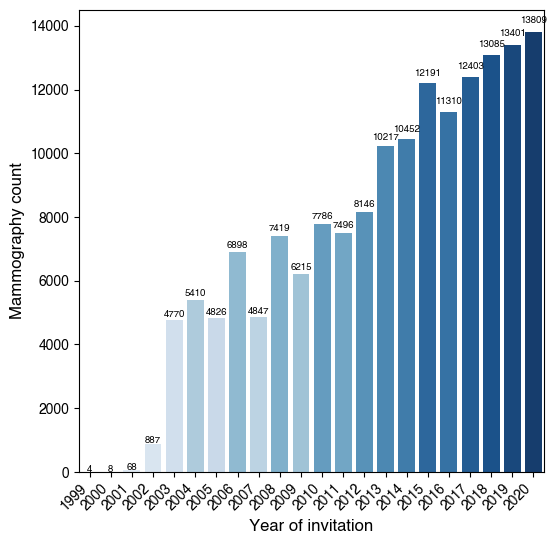

In [9]:
n_mammo_by_year = pd.DataFrame(df_participation.groupby('year_invit').mammo.sum()).reset_index()
pal = sns.color_palette("Blues", len(n_mammo_by_year))
rank = n_mammo_by_year['mammo'].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
chart = sns.barplot(x="year_invit", y="mammo", data=n_mammo_by_year, palette = np.array(pal)[rank], ax = ax)
chart.set_xticklabels(chart.get_xticklabels(),size = 10, rotation=45, horizontalalignment='right')
chart.set_xlabel("Year of invitation",size = 12)
chart.set_ylabel('Mammography count',size = 12)
show_values(chart, digits = 0, fontsize = 7)

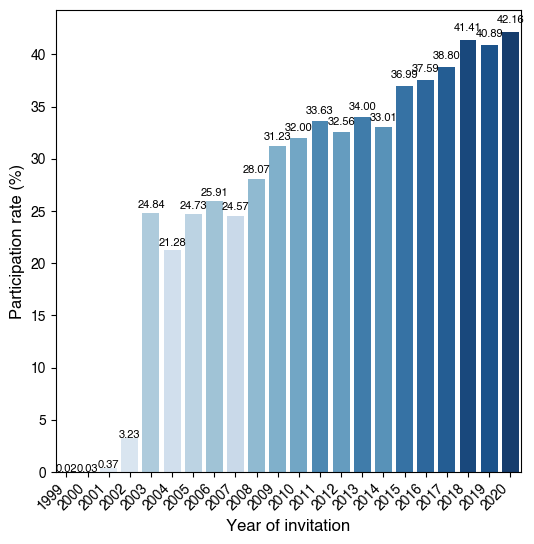

In [10]:
raw_rate_by_year = pd.DataFrame(n_mammo_by_year.set_index('year_invit')['mammo'].div(n_invit_by_year.set_index('year_invit')[0]).mul(100)).reset_index()

pal = sns.color_palette("Blues", len(n_mammo_by_year))
rank = raw_rate_by_year[0].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
chart = sns.barplot(x="year_invit", y=0, data=raw_rate_by_year, palette = np.array(pal)[rank], ax = ax)
chart.set_xticklabels(chart.get_xticklabels(),size = 10, rotation=45, horizontalalignment='right')
chart.set_xlabel("Year of invitation",size = 12)
chart.set_ylabel('Participation rate (%)',size = 12)
show_values(chart)

## Data Aggregation at the Hectometric Scale

In [11]:
# Import the federal dataset of the population distribution at the hectometric scale
statpop = pd.read_csv('/Users/david/Dropbox/PhD/Data/Databases/OFS/ag-b-00.03-vz2020statpop/STATPOP2020.csv',sep = ';')
statpop_ha = statpop.copy()
geometry = [Point(xy) for xy in zip(statpop['E_KOORD'], statpop['N_KOORD'])]
statpop_gdf_point = gpd.GeoDataFrame(statpop, crs=2056, geometry=geometry)   

In [12]:
statpop_communes_ge_point = gpd.sjoin(statpop_gdf_point,communes, predicate = 'intersects').drop('index_right',axis = 1) #Get ha that are in VD canton
_ = statpop_communes_ge_point.copy()
geometry = [Polygon(zip([xy[0],xy[0],xy[0]+100,xy[0]+100],[xy[1],xy[1]+100,xy[1]+100,xy[1]])) for xy in zip(_.E_KOORD, _.N_KOORD)]
statpop_communes_ge_ha = gpd.GeoDataFrame(_, crs=2056, geometry=geometry)      

### Data from Specchio

In [13]:
## Specchio into ha
gdf_specchio_ha = gpd.sjoin(gdf_specchio_mammo,statpop_communes_ge_ha[['RELI','geometry']], predicate = 'intersects').drop('index_right', axis = 1)

In [14]:
df_ha_specchio = pd.DataFrame(gdf_specchio_ha.RELI.unique(), columns = ['RELI'])
df_ha_specchio = pd.merge(df_ha_specchio, statpop_communes_ge_ha[['RELI','geometry']], on = 'RELI')
df_ha_specchio = gpd.GeoDataFrame(df_ha_specchio, crs = 2056, geometry = df_ha_specchio['geometry'])

In [15]:
gdf_specchio_ha['mammo_status'] = 0
gdf_specchio_ha.loc[gdf_specchio_ha.mammography_when == 'Moins de 2 ans', 'mammo_status'] = 1

AttributeError: 'GeoDataFrame' object has no attribute 'mammography_when'

In [20]:
df_specchio.filter(regex='when')

,sym_when_1,sym_when_2,sym_when_3,pcr_when_1,pcr_when_2,pcr_when_3,pcr_when_4,sero_when_1,sero_when_2,sero_when_3,sero_when_4,hosp_when,pcr_when_1_m,pcr_when_1_y,pcr_when_2_m,pcr_when_2_y,pcr_when_3_m,pcr_when_3_y,pcr_when_4_m,pcr_when_4_y,hosp_when_m,hosp_when_y
0,NaN,Janvier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,Mai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Janvier,NaN,NaN,NaN,NaN,NaN,NaN,Juin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mars,NaN,NaN,NaN,NaN,NaN,NaN,Mai,Juin,Novembre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
n_specchio_mammo_by_ha = pd.DataFrame(gdf_specchio_ha.groupby(['RELI']).mammo_status.sum()).reset_index()
n_specchio_by_ha = pd.DataFrame(gdf_specchio_ha.groupby(['RELI']).size()).reset_index()

In [ ]:
n_specchio_by_ha.columns = ['RELI','n_participant']
n_specchio_mammo_by_ha.columns = ['RELI','n_mammo']

In [ ]:
df_ha_specchio = pd.merge(df_ha_specchio, n_specchio_by_ha, on = 'RELI').merge(n_specchio_mammo_by_ha, on = 'RELI', suffixes = ('_invit','_mammo'))

In [ ]:
wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_ha_specchio.geometry.centroid)),16)
e = np.array(df_ha_specchio['n_mammo'])
b = np.array(df_ha_specchio['n_participant'])
ebs_rate = sm.Spatial_Empirical_Bayes(e, b, wnn16)
risk = sm.Excess_Risk(e, b)
df_ha_specchio['tx_screening'] = df_ha_specchio['n_mammo'].div(df_ha_specchio['n_participant']).mul(100)
df_ha_specchio['ebs_rate'] = ebs_rate.r
df_ha_specchio['ebs_rate'] = df_ha_specchio['ebs_rate'].fillna(0)
df_ha_specchio['ebs_rate'] = df_ha_specchio['ebs_rate'].mul(100)

In [ ]:
df_ha_specchio.n_participant.sum()

### Final data processing

In [ ]:
from shapely.ops import nearest_points

def assign_to_nearest_polygon(point, polygons):
    # Calculate the distance between the point and all polygons
    distances = polygons.distance(point)
    # Find the index of the nearest polygon
    nearest_polygon_idx = distances.idxmin()
    return nearest_polygon_idx

# Do the spatial join
gdf_participation_ha = gpd.sjoin(gdf_participation, statpop_communes_ge_ha[['RELI','B20BTOT','geometry']], how='left', predicate='intersects').drop('index_right', axis = 1)

# Find the points that are not within any polygon
missing_points = gdf_participation_ha[gdf_participation_ha.RELI.isna()]

# Assign these points to the nearest polygon
for idx, row in missing_points.iterrows():
    nearest_polygon_idx = assign_to_nearest_polygon(row.geometry, statpop_communes_ge_ha[['geometry']])
    # Update the 'index_right' column to the index of the nearest polygon
    gdf_participation_ha.loc[idx, 'RELI'] = nearest_polygon_idx

In [ ]:
missing_points.numerodossier.nunique()

In [ ]:
# Drop duplicates caused by spatial join (some individuals intersects with multiple ha)
gdf_participation_ha = gdf_participation_ha[~gdf_participation_ha.uuid.duplicated()]

In [ ]:
# n_ovam_reli = df_soc_final_ctrl[df_soc_final_ctrl.stat_ovam == 1].groupby('reli')['stat_ovam'].size()
n_groupage = gdf_participation_ha.groupby(['RELI','groupeage']).size().unstack(fill_value = 0)
n_etatcivil = gdf_participation_ha.groupby(['RELI','etatcivil']).size().unstack(fill_value = 0)
n_year = gdf_participation_ha.groupby(['RELI','year_invit']).size().unstack(fill_value = 0)
# income = gdf_participation_ha.groupby(['RELI']).income_ss.mean()
closest_center = gdf_participation_ha.groupby(['RELI'])['center_nearest'].mean()
density_center = gdf_participation_ha.groupby(['RELI'])['center_density'].mean()
max_center = gdf_participation_ha.groupby(['RELI'])['centre'].sum()

In [ ]:
RELI_geom = statpop_communes_ge_ha.set_index('RELI')['geometry'].to_dict()

In [ ]:
gdf_participation_ha = pd.merge(gdf_participation_ha,pd.get_dummies(gdf_participation_ha['etatcivil']), left_index = True, right_index = True)

In [ ]:
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([1999,2000]), 'year_invit_2y'] = '2000'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2001,2002]), 'year_invit_2y'] = '2002'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2003,2004]), 'year_invit_2y'] = '2004'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2005,2006]), 'year_invit_2y'] = '2006'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2007,2008]), 'year_invit_2y'] = '2008'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2009,2010]), 'year_invit_2y'] = '2010'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2011,2012]), 'year_invit_2y'] = '2012'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2013,2014]), 'year_invit_2y'] = '2014'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2015,2016]), 'year_invit_2y'] = '2016'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2017,2018]), 'year_invit_2y'] = '2018'
gdf_participation_ha.loc[gdf_participation_ha['year_invit'].isin([2019,2020]), 'year_invit_2y'] = '2020'

## Evolution of participation rates over time

### Individual level

In [ ]:
gdf_participation[gdf_participation.mammo > 0].numerodossier.nunique()

In [ ]:
gdf_participation[gdf_participation.numerodepistage > 0].numerodossier.nunique()

In [ ]:
print("Overall mammography (> 0) rate is : ",round(gdf_participation[gdf_participation.numerodepistage > 0].numerodossier.nunique()/gdf_participation.numerodossier.nunique(), 3))

In [ ]:
gdf_participation[gdf_participation.numerodepistage > 0].shape[0]

In [ ]:
print("Overall participation rate is : ",round(gdf_participation[gdf_participation.mammo==1].shape[0]/gdf_participation.shape[0], 3))

### Hectometric scale

In [ ]:
n_mammo_by_2year = pd.DataFrame(gdf_participation_ha.groupby('year_invit_2y').mammo.sum()).reset_index()
n_invit_by_2year = pd.DataFrame(gdf_participation_ha.groupby('year_invit_2y').size()).reset_index()
raw_rate_by_2year = pd.DataFrame(n_mammo_by_2year.set_index('year_invit_2y')['mammo'].div(n_invit_by_2year.set_index('year_invit_2y')[0]), columns = ['raw rate']).reset_index()
# Calculate standard errors
raw_rate_by_2year['se'] = np.sqrt(raw_rate_by_2year['raw rate'] * (1 - raw_rate_by_2year['raw rate']) / n_invit_by_2year[0])

In [ ]:
n_mammo_by_2year_age = pd.DataFrame(gdf_participation_ha.groupby(['year_invit_2y','deprivation_pca_q5']).mammo.sum()).reset_index()
n_invit_by_2year_age = pd.DataFrame(gdf_participation_ha.groupby(['year_invit_2y','deprivation_pca_q5']).size()).reset_index()
raw_rate_by_2year_age = pd.DataFrame(n_mammo_by_2year_age.set_index(['year_invit_2y','deprivation_pca_q5'])['mammo'].div(n_invit_by_2year_age.set_index(['year_invit_2y','deprivation_pca_q5'])[0]), columns = ['raw rate']).reset_index()
# Calculate standard errors
raw_rate_by_2year_age['se'] = np.sqrt(raw_rate_by_2year_age['raw rate'] * (1 - raw_rate_by_2year_age['raw rate']) / n_invit_by_2year_age[0])

In [ ]:
# raw_rate_by_2year[['raw rate','se']] = raw_rate_by_2year[['raw rate','se']].div(100)
raw_rate_by_2year_age[['raw rate','se']] = raw_rate_by_2year_age[['raw rate','se']].mul(100)

In [ ]:
gdf_participation_ha['year_invit_2y_int'] = gdf_participation_ha['year_invit_2y'].astype(int)
gdf_participation_ha['year_invit_2y_int'] = pd.to_datetime(gdf_participation_ha['year_invit_2y_int'], format = '%Y')
gdf_participation_ha['mammo_100'] = gdf_participation_ha['mammo'] *100

In [ ]:
df_plot = gdf_participation_ha[['year_invit_2y_int','mammo_100','deprivation_pca_q5']]

In [ ]:
gdf_participation_ha.groupby('deprivation_pca_q5').ciqmd.mean()

In [ ]:
plt.figure(figsize=(6, 6))
sns.lineplot(x='year_invit_2y_int', y='mammo_100', data=gdf_participation_ha[gdf_participation_ha.year_invit_2y != '2000'])

# plt.title('Participation Rate Evolution Over Time Stratified By Age Group')
plt.xlabel('Biennial interval')
plt.ylabel('Participation rate (%)')
# plt.legend(title='SES Deprivation index (Quintiles)')
# setting x-ticks every 2 years
years = mdates.YearLocator(2) 
ax = plt.gca()
ax.xaxis.set_major_locator(years)
plt.grid(axis = 'y')
# format x-tick labels as YYYY
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.savefig('../Manuscript/Figures - EN/Bar plot - Participation rate by 2y.png', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
sns.lineplot(x='year_invit_2y_int', y='mammo_100', hue='deprivation_pca_q5', palette = 'bwr', data=gdf_participation_ha[gdf_participation_ha.year_invit_2y != '2000'])

# plt.title('Participation Rate Evolution Over Time Stratified By Age Group')
plt.xlabel('Biennial interval')
plt.ylabel('Participation rate (%)')
plt.legend(title='SES Deprivation index (Quintiles)')
# setting x-ticks every 2 years
years = mdates.YearLocator(2) 
ax = plt.gca()
ax.xaxis.set_major_locator(years)
plt.grid(axis = 'y')
# format x-tick labels as YYYY
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.savefig('../Manuscript/Figures - EN/Bar plot - Participation rate by 2y and SES.png', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
gdf_participation_ha['groupeage'] = gdf_participation_ha['groupeage'].astype('str')

In [ ]:
plt.figure(figsize=(6, 6))
chart = sns.lineplot(x='year_invit_2y_int', y='mammo_100', hue='groupeage', data=gdf_participation_ha[gdf_participation_ha.year_invit_2y != '2000'])
show_values(chart)
# plt.title('Participation Rate Evolution Over Time Stratified By Age Group')
plt.xlabel('Biennial interval')
plt.ylabel('Participation rate (%)')
plt.legend(title='Age group')
# setting x-ticks every 2 years
years = mdates.YearLocator(2) 
ax = plt.gca()
ax.xaxis.set_major_locator(years)
plt.grid(axis = 'y')
# format x-tick labels as YYYY
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.savefig('../Manuscript/Figures - EN/Bar plot - Participation rate by 2y and age group.png', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
variable_names = pd.DataFrame({"old": ['groupeage','year_invit_2y','mammo','deprivation_pca_q5'],
                           "new": ['Age group','Binnual interval','Mammography screenings','SES deprivation (quintiles)']})

In [ ]:
tables = []
for year in ['2002','2004','2006','2008','2010','2012','2014','2016','2018','2020']:
    mytable = TableOne(gdf_participation_ha[gdf_participation_ha.year_invit_2y == year],columns= ['mammo','groupeage','deprivation_pca_q5'], groupby= ['mammo'], categorical = ['groupeage','deprivation_pca_q5'], row_percent = True)
    mytable = update_variable_names(mytable.tableone, variable_names,'prevalence')
#     mytable.drop(0, axis=1)
    tables.append(mytable)

In [ ]:
pd.concat(tables, axis = 1).to_clipboard()

In [ ]:
# gdf_participation_ha['participation'] = gdf_participation_ha['mammo'].apply(lambda x: 1 if x == 'participation' else 0)

participation_rates = gdf_participation_ha.groupby(['year_invit_2y', 'groupeage', 'deprivation_pca_q5'])['mammo'].mean()

# The result is a multi-index Series where the index is a combination of 'year', 'age group' and 'SES deprivation index',
# and the values are the participation rates. To convert this to a DataFrame:
participation_rates_df = participation_rates.reset_index()

# Now, you can rename the 'participation' column to 'participation rate':
participation_rates_df.rename(columns={'mammo': 'participation rate'}, inplace=True)

In [ ]:
gdf_participation_ha.groupby('year_invit_2y').mammo.mean().mul(100).round(1).T.to_clipboard()

In [ ]:
participation_rates_df.groupby(['year_invit_2y'])['participation rate'].mean().mul(100).round(1)

In [ ]:
gdf_participation_ha.groupby('year_invit_2y').mammo.sum()

In [ ]:
gdf_participation_ha.groupby('year_invit_2y').size()

In [ ]:
27075/65199

In [ ]:
table = TableOne(participation_rates_df, columns=['year_invit_2y', 'groupeage', 'deprivation_pca_q5', 'participation rate'], groupby= ['year_invit_2y','groupeage','deprivation_pca_q5'])
table.tableone

In [ ]:
# Participation rates according to main demographic characteristics
mytable.to_clipboard()

In [ ]:

pal = sns.color_palette("Blues", len(n_mammo_by_2year))
rank = raw_rate_by_2year['raw rate'].argsort().argsort() 
raw_rate_by_2year['raw rate_perc'] = raw_rate_by_2year['raw rate']*100
raw_rate_by_2year['se_perc'] = raw_rate_by_2year['se']*100
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
chart = sns.barplot(x="year_invit_2y", y='raw rate_perc', data=raw_rate_by_2year, yerr=raw_rate_by_2year['se_perc'], capsize=0.3, errwidth=0.5, color = 'grey', ax = ax)
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel("Binnual interval",size = 14)
chart.set_ylabel('Participation rate (%)',size = 14)
plt.grid(axis = 'y')
show_values(chart)
plt.savefig('../Manuscript/Figures - EN/Bar plot - Participation rate by 2y.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
# _ha = pd.DataFrame(gdf_participation_ha.groupby(['RELI','year_invit']).mammo.sum()).reset_index()
n_mammo_by_ha = pd.DataFrame(gdf_participation_ha.groupby(['RELI','year_invit_2y']).mammo.sum()).reset_index()
n_invit_by_ha = pd.DataFrame(gdf_participation_ha.groupby(['RELI','year_invit_2y']).size()).reset_index()

n_mammo_by_ha.columns = ['RELI','year_invit','n_mammo']
n_invit_by_ha.columns = ['RELI','year_invit','n_invit']

#f.pivot(index='foo', columns='bar', values='baz')
n_mammo_by_ha = n_mammo_by_ha.pivot(index ='RELI',columns = 'year_invit',values = 'n_mammo').fillna(0).reset_index()
n_invit_by_ha = n_invit_by_ha.pivot(index ='RELI',columns = 'year_invit',values = 'n_invit').fillna(0).reset_index()

In [ ]:
# _ha = pd.DataFrame(gdf_participation_ha.groupby(['RELI','year_invit']).mammo.sum()).reset_index()
n_mammo_by_ha_1st = pd.DataFrame(gdf_participation_ha[gdf_participation.numeroinvitation_seq == 1].groupby(['RELI','year_invit_2y']).mammo.sum()).reset_index()
n_invit_by_ha_1st = pd.DataFrame(gdf_participation_ha[gdf_participation.numeroinvitation_seq == 1].groupby(['RELI','year_invit_2y']).size()).reset_index()

n_mammo_by_ha_1st.columns = ['RELI','year_invit','n_mammo']
n_invit_by_ha_1st.columns = ['RELI','year_invit','n_invit']

#f.pivot(index='foo', columns='bar', values='baz')
n_mammo_by_ha_1st = n_mammo_by_ha_1st.pivot(index ='RELI',columns = 'year_invit',values = 'n_mammo').fillna(0).reset_index()
n_invit_by_ha_1st = n_invit_by_ha_1st.pivot(index ='RELI',columns = 'year_invit',values = 'n_invit').fillna(0).reset_index()

## Most visited center for each ha

In [ ]:
_ = gdf_participation_ha.groupby(['RELI','centre'], observed = True).size()
n_mammo_by_ha_by_center = pd.DataFrame(_, columns = ['n']).reset_index()
max_center_by_ha = n_mammo_by_ha_by_center[n_mammo_by_ha_by_center.index.isin(n_mammo_by_ha_by_center.groupby('RELI').n.idxmax().values)]
max_center_by_ha['geometry'] = max_center_by_ha['RELI'].map(RELI_geom)
max_center_by_ha = gpd.GeoDataFrame(max_center_by_ha, crs = 2056, geometry=max_center_by_ha['geometry'])

In [ ]:
_2020 = gdf_participation_ha[gdf_participation_ha.year_invit_2y == '2020'].groupby(['RELI','centre'], observed = True).size()
n_mammo_by_ha_by_center_2020 = pd.DataFrame(_2020, columns = ['n']).reset_index()
max_center_by_ha_2020 = n_mammo_by_ha_by_center_2020[n_mammo_by_ha_by_center_2020.index.isin(n_mammo_by_ha_by_center_2020.groupby('RELI').n.idxmax().values)]
max_center_by_ha_2020['geometry'] = max_center_by_ha_2020['RELI'].map(RELI_geom)
max_center_by_ha_2020 = gpd.GeoDataFrame(max_center_by_ha_2020, crs = 2056, geometry=max_center_by_ha['geometry'])

In [ ]:
max_center_by_ha_2020['geometry'] = max_center_by_ha_2020['RELI'].map(RELI_geom)

In [ ]:
colors_centre = ['#a6cee3',
'#1f78b4',
'#b2df8a',
'#33a02c',
'#fb9a99',
'#e31a1c',
'#fdbf6f',
'#ff7f00',
'#4d4d4d',
'#6a3d9a',
'#fccde5',
'#b15928',
'#8dd3c7',
'#ffffb3',
'#bebada',
'#fb8072',
'#80b1d3']

In [ ]:
dict_color_centre = {i:j for i,j in zip(max_center_by_ha_2020.centre.unique(),colors_centre)}

In [ ]:
hmap_centre = colors.ListedColormap([dict_color_centre[i] for i in max_center_by_ha_2020['centre'].sort_values().unique()])

In [ ]:
ax = max_center_by_ha_2020[max_center_by_ha_2020.n > 1].plot('centre',categorical = True,cmap = hmap_centre, linewidth = 0.01, legend = True, figsize = (12,12), zorder = 3)
communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
ax.set_axis_off()
plt.savefig('../Manuscript/Figures/Most visited centre by ha.png', dpi=300, bbox_inches = 'tight')

In [ ]:
max_center_by_ha_2020.RELI.nunique()

## Physical accessibility to screening centers

In [ ]:
fig, ax = plt.subplots( figsize = (12,12))
gdf_participation_ha[gdf_participation_ha.year_invit == 1999].plot('center_nearest', categorical = True, scheme = 'naturalbreaks', cmap = 'BrBG', legend = True, markersize = 6, ax = ax, legend_kwds = {'title':'Distance au centre le plus proche (m)'}, zorder = 3)
communes.plot(ax = ax, color = 'lightgrey', zorder = 1)
lake.plot(ax = ax, color = 'lightblue',zorder = 2)
ax.set_axis_off()

In [ ]:
fig, ax = plt.subplots( figsize = (12,12))
gdf_participation_ha[gdf_participation_ha.year_invit == 1999].plot('center_density', categorical = True, scheme = 'naturalbreaks', cmap = 'BrBG', legend = True, markersize = 6, ax = ax, legend_kwds = {'title':'Densité de centres \ndans un rayon de 200m'}, zorder = 3)
communes.plot(ax = ax, color = 'lightgrey', zorder = 1)
lake.plot(ax = ax, color = 'lightblue',zorder = 2)
ax.set_axis_off()

## Data aggregation by hectare and 2 year intervals to account for the biennial pattern

In [ ]:
# Considering all invitations
df_ha = pd.DataFrame(gdf_participation_ha.RELI.unique(), columns = ['RELI'])
df_ha = pd.merge(df_ha, statpop_communes_ge_ha[['RELI','geometry']], on = 'RELI')
df_ha = gpd.GeoDataFrame(df_ha, crs = 2056, geometry = df_ha['geometry'])
df_ha = pd.merge(df_ha, n_invit_by_ha, on = 'RELI').merge(n_mammo_by_ha, on = 'RELI', suffixes = ('_invit','_mammo'))

In [ ]:
# Only considering 1st invitations
df_ha_1st = pd.DataFrame(gdf_participation_ha[gdf_participation_ha.numeroinvitation_seq == 1].RELI.unique(), columns = ['RELI'])
df_ha_1st = pd.merge(df_ha_1st, statpop_communes_ge_ha[['RELI','geometry']], on = 'RELI')
df_ha_1st = gpd.GeoDataFrame(df_ha_1st, crs = 2056, geometry = df_ha_1st['geometry'])
df_ha_1st = pd.merge(df_ha_1st, n_invit_by_ha_1st, on = 'RELI').merge(n_mammo_by_ha_1st, on = 'RELI', suffixes = ('_invit','_mammo'))

In [ ]:
figures_folder = Path('../Manuscript/Figures - EN/')

In [ ]:
dfs_year = []
for year in range(2000,2022,2):
    invit_year = str(year)+'_invit'
    mammo_year = str(year)+'_mammo'

    df_ha_year = df_ha[df_ha[invit_year] > 0][['RELI',invit_year,mammo_year,'geometry']]
    wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_ha_year.geometry.centroid)),16)
    e = np.array(df_ha_year[mammo_year])
    b = np.array(df_ha_year[invit_year])
    ebs_rate = sm.Spatial_Empirical_Bayes(e, b, wnn16)
    risk = sm.Excess_Risk(e, b)
    df_ha_year['tx_screening'] = df_ha_year[mammo_year].div(df_ha_year[invit_year]).mul(100)
    df_ha_year['ebs_rate'] = ebs_rate.r
    df_ha_year['ebs_rate'] = df_ha_year['ebs_rate'].fillna(0)
    df_ha_year['ebs_rate'] = df_ha_year['ebs_rate'].mul(100)
    df_ha_year['excess_risk'] = risk.r
    df_ha_year['excess_risk'] = df_ha_year['excess_risk'].fillna(0)
    df_ha_year['er_bins'] = pd.cut(df_ha_year['excess_risk'], bins = [0,0.25,0.5,0.75,1,1.25,2,4,10])
    df_ha_year['ebs_bins'] = pd.cut(df_ha_year['ebs_rate'], bins = [0,20,40,60,80,100])
    df_ha_year['diff_rawrate_vs_ebsrate'] = df_ha_year['tx_screening']-(df_ha_year['ebs_rate'])
    dfs_year.append(df_ha_year)

In [ ]:
dfs_year_1st = []
for year in range(2000,2022,2):
    invit_year = str(year)+'_invit'
    mammo_year = str(year)+'_mammo'

    df_ha_year_1st = df_ha_1st[df_ha_1st[invit_year] > 0][['RELI',invit_year,mammo_year,'geometry']]
    wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_ha_year_1st.geometry.centroid)),16)
    e = np.array(df_ha_year_1st[mammo_year])
    b = np.array(df_ha_year_1st[invit_year])
    ebs_rate = sm.Spatial_Empirical_Bayes(e, b, wnn16)
    risk = sm.Excess_Risk(e, b)
    df_ha_year_1st['tx_screening'] = df_ha_year_1st[mammo_year].div(df_ha_year_1st[invit_year]).mul(100)
    df_ha_year_1st['ebs_rate'] = ebs_rate.r
    df_ha_year_1st['ebs_rate'] = df_ha_year_1st['ebs_rate'].fillna(0)
    df_ha_year_1st['ebs_rate'] = df_ha_year_1st['ebs_rate'].mul(100)
    df_ha_year_1st['excess_risk'] = risk.r
    df_ha_year_1st['excess_risk'] = df_ha_year['excess_risk'].fillna(0)
    df_ha_year_1st['er_bins'] = pd.cut(df_ha_year_1st['excess_risk'], bins = [0,0.25,0.5,0.75,1,1.25,2,4,10])
    df_ha_year_1st['ebs_bins'] = pd.cut(df_ha_year_1st['ebs_rate'], bins = [0,20,40,60,80,100])
    df_ha_year_1st['diff_rawrate_vs_ebsrate'] = df_ha_year_1st['tx_screening']-(df_ha_year_1st['ebs_rate'])
    dfs_year_1st.append(df_ha_year_1st)

In [ ]:
res_folder = Path('../Results/')
year = 2000
for df_year in dfs_year:
    ax = communes.plot(color = 'darkgrey',figsize = (15,15))

    df_year.plot('tx_screening',cmap = 'Blues', linewidth = 0.01, scheme = 'quantiles', legend = True,legend_kwds = {'title': "Taux de participation (brut) (%)",'fmt':"{:.1f}",'loc': 'upper left'},ax = ax)

    lake.plot(color = 'lightblue',ax = ax)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs = 'EPSG:2056')
    lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center',size = 8),axis=1);
    communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center',size = 6),axis=1);

    # add scale bar
    scalebar = ScaleBar(1, units="m", location="lower right")
    ax.add_artist(scalebar)
    ax.set_title('Raw participation rates to the breast cancer screening program %s'% str(year))
    # ax.set_facecolor('black')
    ax.set_axis_off()
    filename = '%s.png' % str(year)
    filepath = res_folder/'Rate maps'/'Raw'/filename
    plt.savefig(filepath,dpi = 120)
    plt.clf()
    plt.close(fig)
    
    year += 2

In [ ]:
year = 2000
for df_year in dfs_year:
    ax = communes.plot(color = 'darkgrey',figsize = (15,15))

    df_year.plot('ebs_rate',cmap = 'Blues', linewidth = 0.01, scheme = 'quantiles', legend = True,legend_kwds = {'title': "Taux de participation (EBS) (%)",'fmt':"{:.1f}",'loc': 'upper left'},ax = ax)

    lake.plot(color = 'lightblue',ax = ax)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs = 2056)
    lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center',size = 8),axis=1);
    communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center',size = 6),axis=1);

    # add scale bar
    scalebar = ScaleBar(1, units="m", location="lower right")
    ax.add_artist(scalebar)
    ax.set_title('SEBS participation rates to the breast cancer screening program in %s'% str(year))
    # ax.set_facecolor('black')
    ax.set_axis_off()
    filename = '%s.png' % str(year)
    filepath = res_folder/'Rate maps'/'Empirical Bayes Smoothing'/filename
    plt.savefig(filepath,dpi = 120)
    plt.clf()
    plt.close(fig)
    
    year += 2

In [ ]:
year = 2000
for df_year in dfs_year:
    ax = communes.plot(color = 'darkgrey',figsize = (15,15))

    df_year.plot('ebs_bins', cmap = 'bwr', legend = True, linewidth = 0.01,legend_kwds = {'title': "Taux de participation (EBS) (%)",'fmt':"{:.1f}",'loc': 'upper left'},ax = ax)

    lake.plot(color = 'lightblue',ax = ax)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs = 'EPSG:2056')
    lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center',size = 8),axis=1);
    communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center',size = 6),axis=1);

    # add scale bar
    scalebar = ScaleBar(1, units="m", location="lower right")
    ax.add_artist(scalebar)
    ax.set_title('SEBS participation rates to the breast cancer screening program in %s'% str(year))
    # ax.set_facecolor('black')
    ax.set_axis_off()
    filename = '%s_binned.png' % str(year)
    filepath = res_folder/'Rate maps'/'Empirical Bayes Smoothing'/filename
    plt.savefig(filepath,dpi = 120)
    plt.clf()
    plt.close(fig)
    
    year += 2

In [ ]:
year = 2000
for df_year in dfs_year:
    try:
        ax = communes.plot(color = 'darkgrey',figsize = (15,15))
        df_year.plot('er_bins', cmap = 'bwr', legend = True, linewidth = 0.01, legend_kwds = {'title': "Taux de participation (ER) (%)",'fmt':"{:.1f}",'loc': 'upper left'}, ax = ax)

        lake.plot(color = 'lightblue',ax = ax)
        lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center',size = 8),axis=1);
        communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center',size = 6),axis=1);
        # add scale bar
        scalebar = ScaleBar(1, units="m", location="lower right")
        ax.add_artist(scalebar)
        ax.set_title('Excess risk of participating to the breast cancer screening program in %s'% str(year))
        # ax.set_facecolor('black')
        ax.set_axis_off()
        filename = '%s.png' % str(year)
        filepath = res_folder/'Rate maps'/'Excess risk'/filename
        plt.savefig(filepath,dpi = 120)
        year += 2
    except:
        pass

## Local spatial autocorrelation

## LISA analysis

In [ ]:
# # from esda import fdr
# year = 2000
# for df_year in dfs_year:
#     wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_year.geometry.centroid)),16)
#     lisawnn16 = pyspace.compute_lisa(df_year,'ebs_rate',wnn16,'b', 999,0.05)
#     fdr_pvalue = fdr(lisawnn16.p_sim, 0.05)
#     df_year['ebs_rate_cl_fdr'] = df_year['ebs_rate_cl']  
#     df_year.loc[df_year['ebs_rate_psim'] >= fdr_pvalue, 'ebs_rate_cl_fdr'] = '0 Non-Significant'
#     fig, ax = pyspace.plotLISAMap_polygons(df_year,'ebs_rate_cl','')
#     ax.set_title(year)
#     filename = 'lisa_giracs_ha_wnn16_005_%s.png' % (str(year))
#     plt.savefig(res_folder/'LISA - Hectares'/filename,dpi = 300, bbox_inches = 'tight')
#     year+=2

## Getis analysis

### Specchio data

In [ ]:
wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_ha_specchio.geometry.centroid)),16)
getiswnn16 = pyspace.compute_getis(df_ha_specchio,'ebs_rate',wnn16, 9999, transform_type='B', p_001 = True)
fdr_pvalue = fdr(getiswnn16.p_sim, 0.05)
df_ha_specchio['ebs_rate_G_cl_fdr'] = df_ha_specchio['ebs_rate_G_cl']  
df_ha_specchio.loc[df_ha_specchio['ebs_rate_G_psim'] >= fdr_pvalue, 'ebs_rate_G_cl_fdr'] = 'Not significant'
fig, ax = pyspace.plotGetisMap(df_ha_specchio,'ebs_rate_G_cl',p_001 = True, commune_name = False)
ax.set_title('SEBS rates of up-to-date mammography (< 2 years) - Specchio')
filename = 'getis_specchio_ha_wnn16_005.png'
plt.savefig(res_folder/'Getis'/filename,dpi = 300, bbox_inches = 'tight')

In [ ]:
colors_getis = ['#1c4978', '#2166ac', '#67a9cf', '#d1e5f0', '#991d2c', '#b2182b', '#ef8a62', '#fddbc7', '#f7f7f7']

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
chart = sns.barplot(x = 'ebs_rate_G_cl', y = 'ebs_rate', data = df_ha_specchio,order=
    ['Cold Spot - p < 0.001','Cold Spot - p < 0.01', 'Cold Spot - p < 0.05', 'Cold Spot - p < 0.1','Hot Spot - p < 0.001', 'Hot Spot - p < 0.01',
     'Hot Spot - p < 0.05', 'Hot Spot - p < 0.1', 'Not significant'],
                        palette=colors_getis, errorbar=('ci', 95),  ax = ax)
chart.set_xlabel('Classes Getis', size=12)
chart.set_ylabel('Taux de participation (%)', size=12)
chart.set_xticklabels(chart.get_xticklabels(), size=8, rotation=45, horizontalalignment='right')

plt.title('Average SEBS Participation Rates (%) by Getis Class - Specchio study', size = 12)
plt.savefig('../Manuscript/Figures/Bar plot - Specchio -  Getis 2020.png', dpi = 300, bbox_inches = 'tight')

## GIRACS data

In [ ]:
reload(pyspace)

In [ ]:
start_year = 2000
for df in dfs_year:
    # Create K-nearest neighbors weights object using the centroids of geometries
    weights_knn = lps.weights.KNN(cKDTree(get_points_array(df.geometry.centroid)), 16)

    # Compute Getis Ord's statistics
    getis_ord_stats = pyspace.compute_getis(df, 'ebs_rate', weights_knn, n_permut=9999, transform_type='B', p_001=True)

    # Adjust p-values using the False Discovery Rate method
    fdr_adjusted_p_value = fdr(getis_ord_stats.p_sim, alpha=0.05)
    
    # Create a new column for Getis Ord's classification with FDR adjustment
    df['ebs_rate_G_cl_fdr'] = df['ebs_rate_G_cl'] 
    df.loc[df['ebs_rate_G_psim'] >= fdr_adjusted_p_value, 'ebs_rate_G_cl_fdr'] = 'Not significant'

    # Plot Getis Ord's map
    fig, ax = pyspace.plotGetisMap(df, 'ebs_rate_G_cl', p_001=True, commune_name=False)
    ax.set_title(start_year)

    # Save the plot
    filename = f'getis_giracs_ha_wnn16_005_{start_year}.png'
    plt.savefig(res_folder / 'Getis' / filename, dpi=300, bbox_inches='tight')

    # Increase the start year by 2 for the next iteration
    start_year += 2


In [ ]:
df.groupby('ebs_rate_G_cl')['ebs_rate'].mean()

In [ ]:
df.groupby('ebs_rate_G_cl')['tx_screening'].mean()

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
chart = sns.barplot(x = 'ebs_rate_G_cl', y = 'ebs_rate', data = df_year,order=
    ['Cold Spot - p < 0.001','Cold Spot - p < 0.01', 'Cold Spot - p < 0.05', 'Cold Spot - p < 0.1','Hot Spot - p < 0.001', 'Hot Spot - p < 0.01',
     'Hot Spot - p < 0.05', 'Hot Spot - p < 0.1', 'Not significant'],
                        palette=colors_getis, errorbar=('ci', 95),  ax = ax)
chart.set_xlabel('Getis Classes', size=12)
chart.set_ylabel('SEBS participation rates (%)', size=12)
chart.set_xticklabels(chart.get_xticklabels(), size=8, rotation=45, horizontalalignment='right')

plt.title('Average SEBS Participation Rates (%) by Getis Class', size = 12)
plt.savefig(figures_folder/'Bar plot - GIRACS -  Getis 2020.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Shared hectares (GIRACS in Specchio) - GIRACS vs Specchio

In [ ]:
df_giracs_2020_specchio = df.copy()

In [ ]:
# df_giracs_2020_specchio = df_giracs_2020_specchio[df_giracs_2020_specchio.RELI.isin(df_ha_specchio.RELI)]

In [ ]:
wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_giracs_2020_specchio.geometry.centroid)),16)

In [ ]:
getiswnn16 = pyspace.compute_getis(df_giracs_2020_specchio,'ebs_rate',wnn16, 9999, transform_type='B', p_001 = True)

In [ ]:
fdr_pvalue = fdr(getiswnn16.p_sim, 0.05)
df_giracs_2020_specchio['ebs_rate_G_cl_fdr'] = df_giracs_2020_specchio['ebs_rate_G_cl']  
df_giracs_2020_specchio.loc[df_giracs_2020_specchio['ebs_rate_G_psim'] >= fdr_pvalue, 'ebs_rate_G_cl_fdr'] = 'Not significant'

In [ ]:
fig, ax = pyspace.plotGetisMap(df_giracs_2020_specchio,'ebs_rate_G_cl',p_001 = True, commune_name = False)

### Participation by Getis class

In [ ]:
colors_getis = ['#1c4978', '#2166ac', '#67a9cf', '#d1e5f0', '#991d2c', '#b2182b', '#ef8a62', '#fddbc7', '#f7f7f7']

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
chart = sns.barplot(x = 'ebs_rate_G_cl', y = 'ebs_rate', data = df,order=
    ['Cold Spot - p < 0.001','Cold Spot - p < 0.01', 'Cold Spot - p < 0.05', 'Cold Spot - p < 0.1','Hot Spot - p < 0.001', 'Hot Spot - p < 0.01',
     'Hot Spot - p < 0.05', 'Hot Spot - p < 0.1', 'Not significant'],
                        palette=colors_getis, errorbar=('ci', 95),  ax = ax)
chart.set_xlabel('Classes Getis', size=12)
chart.set_ylabel('Taux de participation (%)', size=12)
chart.set_xticklabels(chart.get_xticklabels(), size=8, rotation=45, horizontalalignment='right')

plt.title('Taux de participation moyen par classe Getis', size = 12)
plt.savefig('../Manuscript/Figures/Bar plot - Getis 2020.png', dpi = 300, bbox_inches = 'tight')

## Combinaison bivariée GIRACS - Specchio

In [ ]:
df_ha_bivariate = pd.merge(df_ha_specchio, df_giracs_2020_specchio, on = 'RELI', how = 'left', suffixes = ['_specchio','_giracs'])

df_ha_bivariate = gpd.GeoDataFrame(df_ha_bivariate, crs = 2056, geometry = df_ha_bivariate['geometry_specchio'])

df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Hot', na = False) ,'cat_giracs'] = 100
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Not', na = False) ,'cat_giracs'] = 50
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Cold', na = False) ,'cat_giracs'] = 25

df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Hot', na = False) ,'cat_specchio'] = 100
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Not', na = False) ,'cat_specchio'] = 50
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Cold', na = False) ,'cat_specchio'] = 25

df_ha_bivariate = df_ha_bivariate.dropna(subset='ebs_rate_G_cl_giracs')

df_ha_bivariate.drop(['geometry_specchio','geometry_giracs','er_bins','ebs_bins'], axis = 1).to_crs(21781).to_file('../Data/Specchio Data/df_giracs_and_specchio_ha.geojson')

In [ ]:
### percentile bounds defining upper boundaries of color classes
percentile_bounds = [25, 50, 100]
 
### function to convert hex color to rgb to Color object (generativepy package)
def hex_to_Color(hexcode):
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v/256 for v in rgb]
    rgb = Color(*rgb)
    return rgb
 
### get corner colors from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
c00 = hex_to_Color('#3610e0')
c10 = hex_to_Color('#e68422')
c01 = hex_to_Color('#369ed1')
c11 = hex_to_Color('#db0d0d')
 
### now create square grid of colors, using color interpolation from generativepy package
num_grps = len(percentile_bounds)
c00_to_c10 = []
c01_to_c11 = []
colorlist = []
for i in range(num_grps):
    c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
    c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
for i in range(num_grps):
    for j in range(num_grps):
        colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))
### convert back to hex color
colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]

In [ ]:
# df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Hot', na = False) ,'cat_giracs'] = 100
# df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Not', na = False) ,'cat_giracs'] = 50
# df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Cold', na = False) ,'cat_giracs'] = 25

# df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Hot', na = False) ,'cat_specchio'] = 100
# df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Not', na = False) ,'cat_specchio'] = 50
# df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Cold', na = False) ,'cat_specchio'] = 25

In [ ]:
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Hot', na = False) ,'cat_giracs_str'] = 'HS'
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Not', na = False) ,'cat_giracs_str'] = 'NS'
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_giracs.str.contains('Cold', na = False) ,'cat_giracs_str'] = 'CS'

df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Hot', na = False) ,'cat_specchio_str'] = 'HS'
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Not', na = False) ,'cat_specchio_str'] = 'NS'
df_ha_bivariate.loc[df_ha_bivariate.ebs_rate_G_cl_specchio.str.contains('Cold', na = False) ,'cat_specchio_str'] = 'CS'

In [ ]:
df_ha_bivariate ['cat'] = df_ha_bivariate['cat_giracs'].astype(str)+'-'+df_ha_bivariate['cat_specchio'].astype(str)
df_ha_bivariate ['cat_str'] = df_ha_bivariate['cat_giracs_str'].astype(str)+'-'+df_ha_bivariate['cat_specchio_str'].astype(str)

In [ ]:
# df_ha_bivariate.loc[df_ha_bivariate['cat'] == '50-25','cat'] = '25-50'
# df_ha_bivariate.loc[df_ha_bivariate['cat'] == '100-25','cat'] = '25-100'
# df_ha_bivariate.loc[df_ha_bivariate['cat'] == '100-50','cat'] = '50-100'

In [ ]:
df_ha_bivariate.cat_str.value_counts()

(df_ha_bivariate.cat_str.value_counts()/df_ha_bivariate.shape[0]).mul(100).round(1)

In [ ]:
colorlist = ['#3610df',
 '#4f89c2',
 '#0aa5ff',
 '#844aa8',
 '#9c9a9b',
 '#c98671',
 '#e58322',
 '#dbc046',
 '#da0d0d']

In [ ]:
### function to get bivariate color given two percentiles
def get_bivariate_choropleth_color(p1, p2):
    if p1>=0 and p2>=0:
        count = 0
        stop = False
        for percentile_bound_p1 in percentile_bounds:
            for percentile_bound_p2 in percentile_bounds:
                if (not stop) and (p1 <= percentile_bound_p1):
                    if (not stop) and (p2 <= percentile_bound_p2):
                        color = colorlist[count]
                        stop = True
                count += 1
    else:
        color = [0.8,0.8,0.8,1]
    return color

alpha=0.85
dpi=300

### plot map based on bivariate choropleth
fig, ax = plt.subplots(1,1, figsize=(12,12))
attr = 'CIscoreP'
df_ha_bivariate['color_bivariate'] = [get_bivariate_choropleth_color(p1, p2) for p1,p2 in zip(df_ha_bivariate['cat_giracs'].values, df_ha_bivariate['cat_specchio'].values)]
df_ha_bivariate.plot(ax=ax, color=df_ha_bivariate['color_bivariate'], linewidth = 0.01, alpha=alpha, legend=False, zorder=3)
communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', size=6, alpha = 0.8),
               axis=1)
# cx.add_basemap(ax = ax, crs=df_ha_bivariate.crs, source=cx.providers.Stamen.TonerLite)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
### now create inset legend
ax = ax.inset_axes([0.15,0.6,0.25,0.25])
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i,percentile_bound_p1 in enumerate(percentile_bounds):
    for j,percentile_bound_p2 in enumerate(percentile_bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=alpha)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(percentile_bound_p2)
    xticks.append(percentile_bound_p1)
ticks_pos = [x + 0.5 for x in list(range(len(percentile_bounds)))]
# ax.annotate('n=289\n(14.6%)',xy=(2.25,2.5), size = 8)
# ax.annotate('n=270\n(13.7%)',xy=(0.25,0.5), size = 8)
# ax.annotate('n=244\n(12.3%)',xy=(2.25,0.5), size = 8)
# ax.annotate('n=244\n(12.3%)',xy=(1.25,0.5), size = 8)
# ax.annotate('n=230\n(11.6%)',xy=(2.25,1.5), size = 8)
# ax.annotate('n=210\n(10.6%)',xy=(0.25,2.5), size = 8)
# ax.annotate('n=202\n(10.2%)',xy=(0.25,1.5), size = 8)
# ax.annotate('n=173\n(8.8%)',xy=(1.25,2.5), size = 8)
# ax.annotate('n=115\n(5.8%)',xy=(1.25,1.5), size = 8)




_=ax.set_xlim([0,len(percentile_bounds)])
_=ax.set_ylim([0,len(percentile_bounds)])
_=ax.set_xticks(ticks_pos, ['Cold spot','NS','Hot spot'])
_=ax.set_xlabel('Getis GIRACS')
_=ax.set_yticks(ticks_pos, ['Cold spot','NS','Hot spot'])
_=ax.set_ylabel('Getis Specchio')

plt.savefig('../Manuscript/Figures - EN/Bivariate Getis - GIRACS vs Specchio - No basemap.png', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../Manuscript/Figures/Bivariate Getis - GIRACS vs Specchio.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
chart = sns.barplot(x = 'cat_str', y = 'ebs_rate_giracs',palette=df_ha_bivariate[['color_bivariate','cat_str']].drop_duplicates().color_bivariate.to_list(), data = df_ha_bivariate, errorbar=('ci', 95),  ax = ax)
chart.set_xlabel('Classes Getis bivariées', size=12)
chart.set_ylabel('Taux de participation (%) - GIRACS', size=12)

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
chart = sns.barplot(x = 'cat_str', y = 'ebs_rate_specchio',palette=df_ha_bivariate[['color_bivariate','cat_str']].drop_duplicates().color_bivariate.to_list(), data = df_ha_bivariate, errorbar=('ci', 95),  ax = ax)
chart.set_xlabel('Classes Getis bivariées', size=12)
chart.set_ylabel('Taux de participation (%) - Specchio', size=12)
# chart.set_xticklabels(chart.get_xticklabels(), size=8, rotation=45, horizontalalignment='right')


## Evolution des classes 2020 entre 1999 et 2020

In [ ]:
df_all_years = pd.DataFrame()
year = 2000
for df_year in dfs_year:
    df_year['year_invit'] = str(year)
    df_all_years = pd.concat([df_all_years, df_year])
    year +=2

In [ ]:
reli_2020 = df_all_years[df_all_years['2020_mammo'].isnull()==False].RELI.tolist()

df_all_years_2020ha = df_all_years[(df_all_years.RELI.isin(reli_2020))]

In [ ]:
df_all_years_2020ha  = df_all_years_2020ha.set_index('RELI')
df_all_years_2020ha = df_all_years_2020ha.reset_index()

In [ ]:
colors_cl_getis = {'Cold Spot - p < 0.001':'#1c4978',
                    'Cold Spot - p < 0.01':'#2166ac',
                    'Cold Spot - p < 0.05':'#67a9cf',
                    'Cold Spot - p < 0.1':'#d1e5f0',
                    'Hot Spot - p < 0.001':'#991d2c',
                    'Hot Spot - p < 0.01':'#b2182b',
                    'Hot Spot - p < 0.05':'#ef8a62',
                    'Hot Spot - p < 0.1':'#fddbc7',
                    'Not significant':'#f7f7f7'}

In [ ]:
colors_cl = {'0 Non-Significant': 'lightgrey',
             '1 High-High': '#d7191c',
             '2 Low-High': '#abd9e9',
             '3 Low-Low': '#2c7bb6',
             '4 High-Low': '#fdae61'}

In [ ]:
dfs_year[-3].groupby('ebs_rate_G_cl').ebs_rate.mean()

In [ ]:
df_all_years_2020ha_test = df_all_years_2020ha.copy()

In [ ]:
df_all_years_2020ha_test['ebs_rate_G_cl_2020'] = df_all_years_2020ha_test['RELI'].map(dfs_year[-1].set_index('RELI')['ebs_rate_G_cl'].to_dict())

## Temporal evolution of participation rate

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
# the size of A4 paper
g = sns.lineplot(data=df_all_years_2020ha_test[df_all_years_2020ha_test.year_invit != '2000'], x="year_invit", y="ebs_rate", hue = 'ebs_rate_G_cl_2020',hue_order=
    ['Cold Spot - p < 0.001','Cold Spot - p < 0.01', 'Cold Spot - p < 0.05', 'Cold Spot - p < 0.1','Hot Spot - p < 0.001', 'Hot Spot - p < 0.01',
     'Hot Spot - p < 0.05', 'Hot Spot - p < 0.1', 'Not significant'], palette = colors_cl_getis,ax = ax)
for l in g.lines:
    y = l.get_ydata()
    if len(y)>0:
        g.annotate(f'{y[-1]:.1f}', xy=(0.97,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color(), size = 12)
        g.annotate(f'{y[-9]:.1f}', xy=(0.19,y[-9]), xycoords=('axes fraction', 'data'), 
             ha='left', va='center', color=l.get_color(), size = 12)
ax.set_xlabel('Biennial Intervals',labelpad = 10, size = 16)
ax.set_ylabel('SEBS Participation Rates (%)',labelpad = 10, size = 16)
sns.despine()
plt.legend(prop={'size': 14})
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='y')
# plt.title('Evolution du taux de participation au sein des clusters géographiques identifiés en 2020',size = 16)
plt.savefig('../Manuscript/Figures - EN/Evolution temporelle Getis - selon situation 2020.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
# the size of A4 paper
g = sns.lineplot(data=df_all_years_2020ha, x="year_invit", y="ebs_rate", hue = 'ebs_rate_G_cl',hue_order=
    ['Cold Spot - p < 0.001','Cold Spot - p < 0.01', 'Cold Spot - p < 0.05', 'Cold Spot - p < 0.1','Hot Spot - p < 0.001', 'Hot Spot - p < 0.01',
     'Hot Spot - p < 0.05', 'Hot Spot - p < 0.1', 'Not significant'], palette = colors_cl_getis,ax = ax)
for l in g.lines:
    y = l.get_ydata()
    if len(y)>0:
        g.annotate(f'{y[-1]:.1f}', xy=(0.97,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color(), size = 12)
        g.annotate(f'{y[-9]:.1f}', xy=(0.19,y[-9]), xycoords=('axes fraction', 'data'), 
             ha='left', va='center', color=l.get_color(), size = 12)
ax.set_xlabel('Biennial Intervals',labelpad = 10, size = 16)
ax.set_ylabel('SEBS Participation Rates (%)',labelpad = 10, size = 16)
plt.legend(prop={'size': 14})
sns.despine()
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='y')
# plt.title('Evolution du taux de participation au sein des clusters géographiques',size = 16)
plt.savefig('../Manuscript/Figures/Evolution temporelle Getis.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# test = df_all_years[df_all_years.year_invit.isin(['1999','2000'])]

In [ ]:
# Interactive mapping
# fig = px.choropleth_mapbox(test,
#                            geojson=df_haa.to_crs(4326),
#                            locations='RELI',
#                            color='ebs_rate_cl',
#                            hover_name='RELI',
#                            hover_data=['ebs_rate_cl'],
#                            color_continuous_scale='Reds',
#                            animation_frame='year_invit',
#                            mapbox_style='carto-positron',
#                            title='Cumulative Numbers of Crimes in Vancouver Neighborhoods',
#                            center={'lat':df_all_years.centroid.to_crs(4326).y.mean(), 'lon':df_all_years.centroid.to_crs(4326).x.mean()},
#                            zoom=11,
#                            opacity=0.75,
#                            labels={'Count':'Count'},
#                            width=1100,
#                            height=800
#                           )

# fig.show()
# fig.write_html("../Results/test_map.html")

In [ ]:
df_ha['ebs_rate_2000'] = df_ha.RELI.map(dfs_year[0].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2002'] = df_ha.RELI.map(dfs_year[1].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2004'] = df_ha.RELI.map(dfs_year[2].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2006'] = df_ha.RELI.map(dfs_year[3].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2008'] = df_ha.RELI.map(dfs_year[4].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2010'] = df_ha.RELI.map(dfs_year[5].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2012'] = df_ha.RELI.map(dfs_year[6].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2014'] = df_ha.RELI.map(dfs_year[7].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2016'] = df_ha.RELI.map(dfs_year[8].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2018'] = df_ha.RELI.map(dfs_year[9].set_index("RELI").ebs_rate.to_dict())
df_ha['ebs_rate_2020'] = df_ha.RELI.map(dfs_year[10].set_index("RELI").ebs_rate.to_dict())

In [ ]:
df_ha['2020_mammo'].sum()/df_ha['2020_invit'].sum()

In [ ]:
reli_deprivation = gdf_participation_ha.groupby('RELI').deprivation_pca.mean().to_dict()
reli_ciqmd = gdf_participation_ha.groupby('RELI').ciqmd.mean().to_dict()
reli_center_density = gdf_participation_ha.groupby('RELI').center_density.mean().to_dict()

In [ ]:
df_ha['index_socio_pca'] = df_ha.RELI.map(reli_deprivation)

In [ ]:
# df_ha['cumul_LISA'] = 0
# df_ha['cumul_LISA_9909'] = 0
# df_ha['cumul_LISA_1020'] = 0

# df_ha['cumul_LISA_zscore'] = 0
# df_ha['cumul_LISA_9909_zscore'] = 0
# df_ha['cumul_LISA_1020_zscore'] = 0

In [ ]:
# for df_year in dfs_year:
#     _dict = df_year.set_index('RELI')['ebs_rate_Zs'].to_dict()
#     df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_cl'].isin(['1 High-High','4 High-Low'])].RELI),'cumul_LISA'] +=1
#     df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_cl'].isin(['3 Low-Low','2 Low-High'])].RELI),'cumul_LISA'] -=1
#     df_ha['cumul_LISA_zscore'] += df_ha['RELI'].map(_dict)
#     if df_year.year_invit.astype(int).unique()[0] < 2010:
#         df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_cl'].isin(['1 High-High','4 High-Low'])].RELI),'cumul_LISA_9909'] +=1
#         df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_cl'].isin(['3 Low-Low','2 Low-High'])].RELI),'cumul_LISA_9909'] -=1
#     if  df_year.year_invit.astype(int).unique()[0] > 2009 and df_year.year_invit.astype(int).unique()[0] < 2021:
#         df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_cl'].isin(['1 High-High','4 High-Low'])].RELI),'cumul_LISA_1020'] +=1
#         df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_cl'].isin(['3 Low-Low','2 Low-High'])].RELI),'cumul_LISA_1020'] -=1

In [ ]:
df_ha['index_socio_q3'] = pd.qcut(df_ha['index_socio_pca'], 3, labels = False)
reli_q3_deprivation = df_ha.set_index('RELI').index_socio_q3.to_dict()
# df_ha['cumul_LISA_q3'] = pd.qcut(df_ha['cumul_LISA'], 3)

In [ ]:
# dict_cumul_LISA_q3 = df_ha.set_index('RELI')['cumul_LISA_q3'].to_dict()

In [ ]:
# df_ebs_over_years = pd.DataFrame(df_ha.set_index('RELI')[['ebs_rate_2000','ebs_rate_2002','ebs_rate_2004','ebs_rate_2006','ebs_rate_2008','ebs_rate_2010','ebs_rate_2012','ebs_rate_2014','ebs_rate_2016','ebs_rate_2018','ebs_rate_2020']].stack(), columns = ['ebs_rate']).reset_index()
# df_ebs_over_years.columns = ['RELI','year','ebs_rate']
# df_ebs_over_years['year'] = df_ebs_over_years['year'].str.replace('ebs_rate_','')
# df_ebs_over_years['index_socio_pca'] = df_ebs_over_years.RELI.map(reli_deprivation)
# df_ebs_over_years['index_socio_q3'] = df_ebs_over_years.RELI.map(reli_q3_deprivation)
# df_ebs_over_years['cumul_LISA_q3'] = df_ebs_over_years.RELI.map(dict_cumul_LISA_q3)

In [ ]:
# fig, ax = plt.subplots(figsize = (15, 15))
# df_ha.plot('cumul_LISA_1020',cmap = 'bwr', ax = ax,linewidth = 0.01, legend = True, zorder = 3)
# communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
# lake.plot(color = 'lightblue',ax = ax, zorder = 2)
# ax.set_axis_off()

In [ ]:
# fig, ax = plt.subplots(figsize = (15, 15))
# df_ha.plot('cumul_LISA_9909', legend = True, cmap = 'bwr', linewidth = 0.01, ax = ax, zorder = 3)
# communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
# lake.plot(color = 'lightblue',ax = ax, zorder = 2)
# ax.set_axis_off()

In [ ]:
# df_heatmap = df_ebs_over_years.groupby(['cumul_LISA_q3','index_socio_q3']).mean().reset_index()
# df_heatmap = df_heatmap.pivot(index = 'cumul_LISA_q3',columns = 'index_socio_q3', values = 'ebs_rate')
# df_heatmap.columns = ['Low','Medium','High']
# df_heatmap = df_heatmap.sort_values('cumul_LISA_q3', ascending = False)

In [ ]:
df_ha.loc[df_ha['index_socio_q3'] == 0,'index_socio_q3'] = 'Low'
df_ha.loc[df_ha['index_socio_q3'] == 1,'index_socio_q3'] = 'Medium'
df_ha.loc[df_ha['index_socio_q3'] == 2,'index_socio_q3'] = 'High'

In [ ]:
df_ha['index_socio_q3'] = pd.Categorical(df_ha['index_socio_q3'],categories = ['Low','Medium','High'], ordered = True)

In [ ]:
dict_cl = {np.nan:'#bababa',"High":'#d7191c',
3:'#fdae61',
'Medium':'#ffffbf',
1:'#abd9e9',
"Low":'#2c7bb6'}

In [ ]:
hmap = colors.ListedColormap([dict_cl[i] for i in df_ha['index_socio_q3'].sort_values().unique()])

In [ ]:
# df_ha[['cumul_LISA_q3','cumul_LISA_res_q3','index_socio_q3']] = df_ha[['cumul_LISA_q3','cumul_LISA_res_q3','index_socio_q3']].astype(str)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
df_ha.plot('index_socio_q3', legend = True, cmap = hmap, categorical = True,linewidth = 0.01, ax = ax, zorder = 3, legend_kwds = {'title':'Socioeconomic deprivation \nindex (terciles)'})
communes.plot(color = 'lightgrey', alpha = 0.6, ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center', size=12), axis=1)
ax.set_axis_off()
plt.savefig('../Results/Deprivation_index.png', dpi = 98, bbox_inches = 'tight')

In [ ]:
# %config InlineBackend.figure_format ='retina'

# fig, ax = plt.subplots(figsize = (10, 10))
# df_ha.plot('cumul_LISA', legend = True,linewidth = 0.01, cmap = 'bwr', ax = ax, zorder = 3, legend_kwds = {'label':'Cumulated LISA cluster score','shrink':0.5})
# communes.plot(color = 'lightgrey', alpha = 0.6, ax = ax, zorder = 1)
# lake.plot(color = 'lightblue',ax = ax, zorder = 2)
# lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center', size=12), axis=1)
# ax.set_axis_off()

# left, bottom, width, height = [0.2, 0.55, 0.14, 0.12]
# ax2 = fig.add_axes([left, bottom, width, height])
# sns.set_context("paper")
# x_label = 'Deprivation'
# y_label = 'Cumulated cluster score'
# chart = sns.heatmap(df_heatmap, cmap = 'Blues', alpha = 0.8, cbar_kws={'label': 'Participation rate (%)'})
# chart.set_xticklabels(chart.get_xticklabels(),size=8, rotation=0, horizontalalignment='center')
# chart.set_yticklabels(chart.get_yticklabels(),color = 'white', size=0, rotation=0, horizontalalignment='right')

# plt.tick_params(bottom = False, left = False)

# chart.set_xlabel(x_label, size=10)
# chart.set_ylabel(y_label, size=10)


# plt.savefig('../Results/LISA - Hectares/Cumulated LISA/Biennial_LISA_cumulated_raw_wnn16_005.png', dpi = 300, bbox_inches = 'tight')
# # plt.savefig('../Results/LISA - Hectares/Cumulated LISA/Biennial_LISA_cumulated_raw_wnn16_005.pdf', bbox_inches = 'tight')

In [ ]:
# high_low_ebs_raw = df_ha. groupby('cumul_LISA_q3').mean().round(1).filter(regex = 'ebs')
# high_low_ebs_adj = df_ha.groupby('cumul_LISA_res_q3').mean().round(1).filter(regex = 'ebs')

In [ ]:
# fig, ax = plt.subplots(figsize = (15,8))
# # the size of A4 paper
# g = sns.lineplot(data=df_all_years_2018ha.groupby(['year_invit','ebs_rate_cl']).mean().reset_index(), x="year_invit", y="ebs_rate", hue = 'ebs_rate_cl', palette = colors_cl, ci = 95,ax = ax)
# for l in g.lines:
#     y = l.get_ydata()
#     if len(y)>0:
#         g.annotate(f'{y[-1]:.1f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
#                      ha='left', va='center', color=l.get_color(), size = 12)
# ax.set_xlabel('Date',labelpad = 10, size = 16)
# ax.set_ylabel('Taux de vaccination (%)',labelpad = 10, size = 16)
# plt.legend(prop={'size': 14})
# plt.xticks(size = 12)
# plt.yticks(size = 12)
# ax.grid('on', which='minor', axis='x' )
# ax.grid('on', which='major', axis='y')
# plt.title('Evolution du taux de participation au sein des clusters locaux (LISA) identifiés en 2018',size = 16)

In [ ]:
# df_ha.groupby('index_socio_q5').agg({'mean','std'}).round(1).filter(regex = 'ebs')

## Space-time cube clustering

In [ ]:
import pymannkendall as mk
from itertools import groupby
from operator import itemgetter

In [ ]:
df_space_time_cube = pd.concat(dfs_year[1:])[['RELI','year_invit','ebs_rate_G_Zs','ebs_rate_G_cl','geometry']]
df_space_time_cube['time'] = df_space_time_cube['year_invit'].astype(int).sub(2002).div(2)
# df_space_time_cube.groupby('RELI').ebs_rate_G_cl.apply(list)

In [ ]:
def get_consecutive(lst, max_time):
    consec_lsts = []
    for k, g in groupby(enumerate(lst), lambda ix : ix[0] - ix[1]):
        consecutive_list = list(map(itemgetter(1), g))
#         print(consecutive_list)
        consec_lsts.append(consecutive_list)
#         print(len(consec_lsts))
        if len(consec_lsts) > 1:
            return np.nan
        else:
            if max_time in consecutive_list and len(consecutive_list)>1:
                
                return consecutive_list
            else:
                return np.nan

Point chaud consécutif

Localisation représentant une série unique ininterrompue d’au moins deux groupes de points chauds statistiquement significatifs dans les intervalles temporels finaux. La localisation n’a jamais été un point chaud statistiquement significatif avant la série finale de points chauds et moins de 90 pour cent de tous les groupes représentent des points chauds statistiquement significatifs.

Intensification de point chaud

Localisation ayant représenté un point chaud statistiquement significatif pour 90 pour cent des intervalles temporels, y compris l’intervalle temporel final. En outre, l'intensité de l'agrégation de nombres élevés dans chaque intervalle temporel augmente globalement et cette augmentation est statistiquement significative.

Point chaud persistant

Localisation ayant représenté un point chaud statistiquement significatif pour 90 pour cent des intervalles temporels, sans tendance perceptible de l’intensité de l’agrégation au fil du temps.

Point chaud diminuant

Localisation ayant représenté un point chaud statistiquement significatif pour 90 pour cent des intervalles temporels, y compris l’intervalle temporel final. En outre, l'intensité de l'agrégation dans chaque intervalle temporel diminue globalement et cette diminution est statistiquement significative.

Point chaud sporadique

Point chaud statistiquement significatif pour l’intervalle temporel final avec un historique de point chaud réactivé, puis désactivé. Moins de 90 % des intervalles temporels ont été des points chauds statistiquement significatifs et aucun des intervalles temporels n’a été un point froid statistiquement significatif.

Point chaud oscillant

Point chaud statistiquement significatif pour l'intervalle temporel final et qui a également été un point froid statistiquement significatif durant un intervalle temporel précédent. Moins de 90 pour cent des intervalles temporels ont été des points chauds statistiquement significatifs.

Point chaud historique

La période la plus récente n’est pas chaude, mais au moins 90 pour cent des intervalles temporels ont été des points chauds statistiquement significatifs.

In [ ]:
def spatiotemporal_getis_cats_prep(df,class_col, z_col, max_time):
    df_cats_prep = pd.DataFrame(pd.DataFrame(df.RELI.unique(), columns = ['RELI'])).set_index('RELI')
    getis_cl_lst = df.groupby('RELI')[class_col].apply(list)
    getis_Zs_lst = df.groupby('RELI')[z_col].apply(list)
    getis_hs_index = getis_cl_lst.apply(lambda x: [i for i, s in enumerate(x) if 'Hot' in s])
    getis_cs_index = getis_cl_lst.apply(lambda x: [i for i, s in enumerate(x) if 'Cold' in s])
    df_cats_prep['n_periods'] = getis_cl_lst.apply(len)

    df_cats_prep['hs_index'] = getis_hs_index
    df_cats_prep['cs_index'] = getis_cs_index
    df_cats_prep['all_na_cnt'] = getis_cl_lst.apply(lambda x: sum(pd.isnull(s) for s in x))
    df_cats_prep['all_hs_cnt'] = getis_cl_lst.apply(lambda x: sum('Hot' in s for s in x))
    df_cats_prep['all_cs_cnt'] = getis_cl_lst.apply(lambda x: sum('Cold' in s for s in x))
    df_cats_prep['perc_hs'] = df_cats_prep['all_hs_cnt'].div(df['time'].nunique()).mul(100)
    df_cats_prep['perc_cs'] = df_cats_prep['all_cs_cnt'].div(df['time'].nunique()).mul(100)

    # Temporal trend
    df_cats_prep['trend'] = getis_Zs_lst.apply(lambda x: mk.original_test(x).trend if len(x) > 1 else np.nan)
    
    # Consecutive hot spot, consecutive cold spot
    df_cats_prep['consecutive_hs'] = getis_hs_index.apply(lambda x: get_consecutive(x, max_time))
    df_cats_prep['consecutive_cs'] = getis_cs_index.apply(lambda x: get_consecutive(x, max_time))
    df_cats_prep.loc[(df_cats_prep.hs_index.astype(str) == '[%s]'%(max_time)), 'class'] = 'Nouveau point chaud'
    df_cats_prep.loc[(df_cats_prep.perc_hs < 90)&(df_cats_prep.consecutive_hs.isnull()==False), 'class'] = 'Point chaud consécutif'
    df_cats_prep.loc[(df_cats_prep.perc_hs >= 90)&(df_cats_prep.consecutive_hs.isnull()==False)&(df_cats_prep.trend == 'increasing'), 'class'] = 'Intensification de point chaud'
    df_cats_prep.loc[(df_cats_prep.perc_hs >= 90)&(df_cats_prep.consecutive_hs.isnull()==False)&(df_cats_prep.trend == 'no trend'), 'class'] = 'Point chaud persistant'
    df_cats_prep.loc[(df_cats_prep.perc_hs >= 90)&(df_cats_prep.consecutive_hs.isnull()==False)&(df_cats_prep.trend == 'decreasing'), 'class'] = 'Point chaud diminuant'
    df_cats_prep.loc[(df_cats_prep.perc_hs < 90)&(df_cats_prep.hs_index.astype(str).str.contains('%s]'%(max_time)))&(df_cats_prep.all_cs_cnt == 0)&(df_cats_prep.all_hs_cnt > 1), 'class'] = 'Point chaud sporadique'
    df_cats_prep.loc[(df_cats_prep.perc_hs < 90)&(df_cats_prep.hs_index.astype(str).str.contains('%s]'%(max_time)))&(df_cats_prep.all_cs_cnt > 0), 'class'] = 'Point chaud oscillant'
    df_cats_prep.loc[(df_cats_prep.perc_hs >= 50)&(df_cats_prep.hs_index.astype(str).str.contains('%s]'%(max_time)) == False), 'class'] = 'Point chaud historique'

    df_cats_prep.loc[(df_cats_prep.cs_index.astype(str) == '[%s]'%(max_time)), 'class'] = 'Nouveau point froid'
    df_cats_prep.loc[(df_cats_prep.perc_cs < 90)&(df_cats_prep.consecutive_cs.isnull()==False), 'class'] = 'Point froid consécutif'
    df_cats_prep.loc[(df_cats_prep.perc_cs >= 90)&(df_cats_prep.consecutive_cs.isnull()==False)&(df_cats_prep.trend == 'increasing'), 'class'] = 'Intensification de point froid'
    df_cats_prep.loc[(df_cats_prep.perc_cs >= 90)&(df_cats_prep.consecutive_cs.isnull()==False)&(df_cats_prep.trend == 'no trend'), 'class'] = 'Point froid persistant'
    df_cats_prep.loc[(df_cats_prep.perc_cs >= 90)&(df_cats_prep.consecutive_cs.isnull()==False)&(df_cats_prep.trend == 'decreasing'), 'class'] = 'Point froid diminuant'
    df_cats_prep.loc[(df_cats_prep.perc_cs < 90)&(df_cats_prep.cs_index.astype(str).str.contains('%s]'%(max_time)))&(df_cats_prep.all_hs_cnt == 0)&(df_cats_prep.all_cs_cnt > 1), 'class'] = 'Point froid sporadique'
    df_cats_prep.loc[(df_cats_prep.perc_cs < 90)&(df_cats_prep.cs_index.astype(str).str.contains('%s]'%(max_time)))&(df_cats_prep.all_cs_cnt > 0), 'class'] = 'Point froid oscillant'
    df_cats_prep.loc[(df_cats_prep.perc_cs >= 50)&(df_cats_prep.cs_index.astype(str).str.contains('%s]'%(max_time)) == False), 'class'] = 'Point froid historique'
    df_cats_prep.loc[df_cats_prep['class'].isnull(),'class'] = 'Aucun modèle détecté'
    return df_cats_prep

In [ ]:
# df_space_time_cube.loc[df_space_time_cube['ebs_rate_G_cl'].str.contains('p < 0.1'),'ebs_rate_G_cl'] = 'Not significant'

In [ ]:
df_emergent_getis = spatiotemporal_getis_cats_prep(df_space_time_cube,'ebs_rate_G_cl','ebs_rate_G_Zs', 9)

In [ ]:
df_emergent_getis['class'] = translate_cat(df_emergent_getis['class'],'FR')

In [ ]:
df_emergent_getis_n10 = df_emergent_getis[df_emergent_getis.n_periods == 10]

In [ ]:
df_emergent_getis['class'].value_counts()

In [ ]:
df_emergent_getis['class'].value_counts()-df_emergent_getis_n10['class'].value_counts()

In [ ]:
df_emergent_getis_n10['class'].value_counts()

In [ ]:
df_ha = df_ha.set_index('RELI')

In [ ]:
df_emergent_getis['geometry'] = df_ha['geometry']
df_emergent_getis_n10['geometry'] = df_ha['geometry']

In [ ]:
df_all_years_2020ha = df_all_years_2020ha.set_index('RELI')
df_all_years_2020ha['class_emergent_getis'] = df_emergent_getis['class']
df_all_years_2020ha['class_emergent_getis_n10'] = df_emergent_getis_n10['class']

In [ ]:
df_emergent_getis = gpd.GeoDataFrame(df_emergent_getis, crs = 2056, geometry = df_emergent_getis['geometry'])
df_emergent_getis_n10 = gpd.GeoDataFrame(df_emergent_getis_n10, crs = 2056, geometry = df_emergent_getis_n10['geometry'])

In [ ]:
# df_ha = df_ha.set_index("RELI")

In [ ]:
colors_cl_getis = { 'Nouveau point froid':'#eff3ff',
                    'Point froid diminuant': "#80cdc1",
                    'Point froid persistant':'#313695',
                    'Point froid historique':'#2166ac',
                    'Point froid sporadique':'#67a9cf',
                    'Point froid oscillant':'#d1e5f0',
                    'Intensification de point froid':'#c51b8a',
                    'Point chaud persistant':'#e41a1c',
                    'Point chaud historique':'#b2182b',
                    'Point chaud sporadique':'#ef8a62',
                    'Point chaud oscillant':'#fddbc7',
                    'Intensification de point chaud':'#e7298a',
                    'Nouveau point chaud':'#ffeda0',
                    'Point chaud diminuant': "#fb9a99",
                    'Aucun modèle détecté':'#f0f0f0'}

colors_cl_getis_en = {
'New cold spot': '#eff3ff',
'Diminishing cold spot': "#80cdc1",
'Persistent cold spot': '#313695',
'Historical cold spot': '#2166ac',
'Sporadic cold spot': '#67a9cf',
'Oscillating cold spot': '#d1e5f0',
'Cold spot intensification': '#c51b8a',
'Persistent hot spot': '#e41a1c',
'Historical hot spot': '#b2182b',
'Sporadic hot spot': '#ef8a62',
'Oscillating hot spot': '#fddbc7',
'Hot spot intensification': '#e7298a',
'New hot spot': '#ffeda0',
'Diminishing hot spot': "#fb9a99",
'No pattern detected': '#f0f0f0'
}
hmap = colors.ListedColormap([colors_cl_getis_en[i] for i in df_emergent_getis['class'].sort_values().unique()])

### Map screening center

In [ ]:
gdf_centre = gpd.read_file('../Data/BC_ScreeningCenters.geojson',driver = 'GeoJSON')

gdf_centre.crs = 4326

gdf_centre['geometry'] = gpd.points_from_xy(gdf_centre.lon, gdf_centre.lat)

gdf_centre = gdf_centre.to_crs(2056)

gdf_centre['year_start'] = gdf_centre['year_start'].astype(int)

from adjustText import adjust_text

ax = communes[communes.NAME.isin(['Genève','Carouge (GE)','Cologny','Pregny-Chambésy','Bellevue','Vernier','Collonge-Bellerive','Chêne-Bougeries','Chêne-Bourg','Onex','Lancy','Meyrin','Genthod','Versoix'])].plot(color = 'lightgrey', zorder = 1, figsize = (12,12))
# lake.plot(color = 'lightblue',ax = ax, zorder = 2)
ax.set_axis_off()
gdf_centre.plot('year_start', categorical = True
                , markersize = 30, alpha = 1, marker = 'x', legend = True, ax = ax, zorder = 6, legend_kwds = {'title':'Année de début','fontsize':10})
texts = gdf_centre.apply(lambda x: ax.annotate(text=x.center_name, xy=x.geometry.centroid.coords[0], ha='center', size=8, alpha = 1),
               axis=1)
adjust_text(texts)

plt.savefig('../Manuscript/Figures/Centres de dépistage.png', dpi = 300, bbox_inches = 'tight')

## Emerging hot spots map

In [ ]:
n_by_n_periods = pd.DataFrame(df_emergent_getis.groupby('n_periods').size(), columns = ['n']).reset_index()
perc_by_n_periods = pd.DataFrame(df_emergent_getis.groupby('n_periods').size(), columns = ['n']).reset_index()
perc_by_n_periods['n'] = perc_by_n_periods['n']/66.55

In [ ]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='n_periods', y='n', data=n_by_n_periods, color = 'grey', ax=ax)
# Add title and labels
# plt.title('Nombre de Patients par Assureur', fontsize=16)
plt.xlabel('Number of represented time intervals', fontsize=12)
plt.ylabel('Number of hectares', fontsize=12)
# Despine visual elements for a cleaner look
sns.despine()
plt.grid(axis='y')
plt.savefig('../Manuscript/Figures - EN/Distribution of represented periods.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='n_periods', y='n', data=perc_by_n_periods, color = 'grey', ax=ax)
# Add title and labels
# plt.title('Nombre de Patients par Assureur', fontsize=16)
plt.xlabel('Number of represented time intervals', fontsize=12)
plt.ylabel('Percentage of hectares', fontsize=12)
# Despine visual elements for a cleaner look
sns.despine()
plt.grid(axis='y')
plt.savefig('../Manuscript/Figures - EN/Distribution of represented periods (%).png', dpi = 300, bbox_inches = 'tight')

In [ ]:
df_emergent_getis['class'].value_counts() - df_emergent_getis_n10['class'].value_counts()

In [ ]:
(df_emergent_getis['class'].value_counts() - df_emergent_getis_n10['class'].value_counts())/df_emergent_getis.shape[0]

In [ ]:
y = df_emergent_getis['class'] + ' [' + df_emergent_getis['class'].map(df_emergent_getis['class'].value_counts()).astype(str) + ']'
ax = df_emergent_getis.plot(y, cmap = hmap, figsize = (12,12), zorder = 3, linewidth = 0.01, legend = True, legend_kwds = {'title':'Categories [n hectares]','fontsize':10})
communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
ax.set_axis_off()
# communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', size=6, alpha = 0.8), axis=1)
lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center', size=12, alpha = 0.8), axis=1)

legend = ax.get_legend()
# Change the fontsize
legend.get_title().set_fontsize('12')  # You can adjust the number to increase or decrease the size

# gdf_centre.plot(c = '#31a354', markersize = 30, alpha = 1, marker = 'x', ax = ax, zorder = 6)

plt.savefig('../Manuscript/Figures - EN/Emergent Getis.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
df_emergent_getis['class'].value_counts().sum()

In [ ]:
n_women_by_reli = gdf_participation_ha.groupby('RELI')['numerodossier'].nunique()
n_mammo_by_reli = gdf_participation_ha.groupby('RELI')['mammo'].sum()

In [ ]:
df_emergent_getis['n_mammo'] = df_emergent_getis.index.map(n_mammo_by_reli)
df_emergent_getis['n_women_by_reli'] = df_emergent_getis.index.map(n_women_by_reli)


In [ ]:
df_emergent_getis.groupby('class')['n_women_by_reli'].sum()

In [ ]:
y = df_emergent_getis_n10['class'] + ' [' + df_emergent_getis_n10['class'].map(df_emergent_getis_n10['class'].value_counts()).astype(str) + ']'
ax = df_emergent_getis_n10.plot(y, cmap = hmap, figsize = (12,12), zorder = 3, linewidth = 0.01, legend = True, legend_kwds = {'title':'Categories [n hectares]','fontsize':10})
communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
ax.set_axis_off()
# communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', size=6, alpha = 0.8), axis=1)
lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center', size=12, alpha = 0.8), axis=1)
legend = ax.get_legend()
# Change the fontsize
legend.get_title().set_fontsize('12')  # You can adjust the number to increase or decrease the size

# gdf_centre.plot(c = '#31a354', markersize = 30, alpha = 1, marker = 'x', ax = ax, zorder = 6)

plt.savefig('../Manuscript/Figures - EN/Emergent Getis - 10 periods only.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
import utils

In [ ]:
reload(utils)

In [ ]:
from utils import masked_emergent_getis

In [ ]:
for category in df_emergent_getis['class'].unique():
    print(category)
    masked_emergent_getis(df_emergent_getis, gdf_centre, category, colors_cl_getis_en)
    plt.savefig('../Manuscript/Figures - EN/Biennial_2002_2020_emergent_Getis_%s.png'%(category), dpi = 300, bbox_inches = 'tight')

In [ ]:
data_2020 = df_all_years_2020ha[df_all_years_2020ha.year_invit == '2020']

In [ ]:
data_2020['class_emergent_getis'] = data_2020['class_emergent_getis'].astype('string')

In [ ]:
sns.set_context("paper")

In [ ]:
def plot_participation_by_class(data, y_column, x_column, annotator_pairs, plot_type, output_file, colors_cl_getis_en, context="paper", figsize=(6, 6), rotation=45, size=8):
    sns.set_context(context)
    fig, ax = plt.subplots(figsize=figsize)
    colors_emergentGetis = [colors_cl_getis_en[i] for i in data[x_column].sort_values().unique()]
    ylim_max = data[y_column].quantile(q=0.99)
    x_label = 'Emerging hot spot ctegories'
    if plot_type == 'barplot':
        chart = sns.barplot(x=x_column, y=y_column, order = list([i for i in data[x_column].sort_values().unique()]),
                        palette=colors_emergentGetis, data=data, ax=ax)
    if plot_type == 'violinplot':
        chart = sns.violinplot(x=x_column, y=y_column,order = list([i for i in data[x_column].sort_values().unique()]),
                    palette=colors_emergentGetis, showfliers=True, data=data, ax=ax)
    chart.set_xticklabels(chart.get_xticklabels(), size=size, rotation=rotation, horizontalalignment='right')
#     chart.set_title('{} par classe'.format(y_column, size=16))
    chart.set_xlabel(x_label, size=12)
    chart.set_ylabel('SEBS Participation Rate (%)', size=12)

    annotator = Annotator(chart, pairs=annotator_pairs, data=data, x=x_column, y=y_column, order = list([i for i in data[x_column].sort_values().unique()]))
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="Bonferroni")
    annotator.apply_and_annotate()
    # chart.set_ylim([0, ylim_max])
    plt.savefig(output_file, dpi = 300, bbox_inches = 'tight')

In [ ]:
plot_participation_by_class(data_2020, 'ebs_rate', 'class_emergent_getis', [('No pattern detected',"Persistent cold spot"), ('No pattern detected','Persistent hot spot')],'barplot', '../Manuscript/Figures - EN/Bar plot - Emergent Getis - Tx Participation.png', colors_cl_getis_en)

In [ ]:
plot_participation_by_class(data_2020, 'ebs_rate', 'class_emergent_getis', [('No pattern detected',"Persistent cold spot"), ('No pattern detected','Persistent hot spot')],'violinplot', '../Manuscript/Figures/Violin plot - Emergent Getis - Tx Participation.png', colors_cl_getis_en)

In [ ]:
gdf_participation_ha[gdf_participation_ha.year_invit_2y == '2020'].groupby('RELI')[['center_nearest','center_density','ciqmd','B20BTOT']].mean()

In [ ]:
data_2020

In [ ]:
data_2020 = pd.merge(data_2020, gdf_participation_ha[gdf_participation_ha.year_invit_2y == '2020'].groupby('RELI')[['center_nearest','center_density','ciqmd','B20BTOT']].mean(), left_index = True, right_index = True, how = 'left')

In [ ]:
# Define a list of the columns you're interested in
columns = [
    'RELI', 'rpnoce', 'rpncam', 'rpncas', 'rpnceu', 'rpneeu', 'rpneceu', 
    'rpnfe', 'rpnme', 'rpnnaf', 'rpnnam', 'rpnneu', 'rpnnweu', 'rpnsam', 
    'rpnsas', 'rpnseas', 'rpnseeu', 'rpnsweu', 'rpnsubaf', 'rpnweu', 
    'rad3sec', 'rad3tert', 'rprprot', 'rprcath', 'rprochr', 'rprjew', 
    'rprmusl', 'rproth', 'rprnorel', 'rpnch', 'rphhpriv', 'rpfnone', 
    'rpfobl', 'rpfgen', 'rpfprof', 'rpfmat', 'rpfprsf', 'rpfprss', 
    'rpfbac', 'rpfmas', 'rpfphd', 'rad', 'radf', 'radune', 'radslib', 
    'tertiary_education', 'rpforeign', 'wo_tertiary_education', 
    'inv_ciqmd', 'inv_dmdrent', 'rad3primsec', 'rp65+', 'rphh3p-', 
    'rphh3p+', 'dmdrent', 'ptot', 'deprivation_pca', 'deprivation_pca_q5', 
    'diff_years', 'mammo_last_invite', 'participation_change', 'mammo', 
    'E', 'N', 'age_cat', '30-34', '35-39', '40-44', '45-49', '50-54', 
    '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94'
]

# Now perform the selection and grouping
df_sociodemo_access_RELI = gdf_participation_ha[columns].groupby('RELI').mean()


In [ ]:
df_comparison_emergent_getis = pd.merge(data_2020,df_sociodemo_access_RELI, left_index = True, right_index = True)

df_comparison_emergent_getis['rpam'] = df_comparison_emergent_getis.filter(regex = 'cam|nam|sam').sum(axis = 1)
df_comparison_emergent_getis['rpaf'] = df_comparison_emergent_getis.filter(regex = 'af').sum(axis = 1)
df_comparison_emergent_getis['rpas'] = df_comparison_emergent_getis.filter(regex = 'cas|sas|seas|rpnme').sum(axis = 1)
df_comparison_emergent_getis['rpeu'] = df_comparison_emergent_getis.filter(regex = 'ceu|weu|neu|eeu').sum(axis = 1)

In [ ]:
colors_emergentGetis = [colors_cl_getis_en[i] for i in df_comparison_emergent_getis['class_emergent_getis'].sort_values().unique()]
ylim_max = df_comparison_emergent_getis['ebs_rate'].quantile(q=0.99)
x_label = ''
# y_label = 'Taux de participation (%) en 2020'
features = ['ptot','ciqmd','dmdrent','deprivation_pca','center_density','center_nearest','wo_tertiary_education','rpnch',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '70-74',
 'rprprot',
 'rprcath',
 'rprochr',
 'rprjew',
 'rprmusl',
 'rprnorel', 'rpncam','rpnnam','rpnsam','rpaf','rpas','rpeu','rpnme']
y_labels = ["Nombre d'habitants",'Revenu médian du ménage (CHF)', 'Revenu médian (x1000 CHF)', 'Loyer médian (CHF)','Précarité SES','Accès - Densité de centres','Accès - Centre le plus proche (m)','Prop. de la pop. \n sans éduc. supérieure (%)','Prop. de la pop.\n de nationalité suisse (%)','Prop. de 50-54 ans (%)','Prop. de 55-59 ans (%)','Prop. de 60-64 ans (%)','Prop. de 65-69 (%)','Prop. de 70-74 ans (%)','Prop. de rel. prostestante (%)','Prop. de rel. catholique (%)','Prop. de rel. chrétienne (%)','Prop. de rel. juive (%)','Prop. de religion musulmane (%)','Prop de non-religieux (%)','Prop. origine amérique centrale','Prop. origine amérique du Nord','Prop. origine amérique du Sud','Prop. origine continent africain','Prop. origine continent asiatique','Prop. origine continent européen','Prop. origine moyen-orient']

In [ ]:
for feature, y_label in zip(features, y_labels):
    fig, ax = plt.subplots(figsize=(4, 4))
#     f = plt.figure(figsize = (5,5))
    chart = sns.barplot(x='class_emergent_getis', y=feature,order = list([i for i in df_comparison_emergent_getis['class_emergent_getis'].sort_values().unique()]),
                        palette=colors_emergentGetis, data=df_comparison_emergent_getis, ax=ax)
    chart.set_xticklabels(chart.get_xticklabels(), size=8, rotation=45, horizontalalignment='right')
    chart.set_title('{} par classe'.format(y_label, size=16))
    chart.set_xlabel(x_label, size=10)
    chart.set_ylabel(y_label, size=10)
    plt.tight_layout()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# n = 100

# # For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
#     ax.scatter(xs, ys, zs, c=c, marker=m)
#     ax.add_collection3d(communes)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))
# the size of A4 paper
g = sns.lineplot(data=df_all_years_2020ha[df_all_years_2020ha.year_invit != '2000'].reset_index(), x="year_invit", y="ebs_rate", hue = 'class_emergent_getis', linewidth = 2, palette = colors_cl_getis_en,ax = ax)
for l in g.lines:
    y = l.get_ydata()
    if len(y)>0:
        g.annotate(f'{y[-1]:.1f}', xy=(1.02,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='right', va='center', color=l.get_color(), size = 10)
ax.set_xlabel('Biennial interval',labelpad = 10, size = 16)
ax.set_ylabel('SEBS Participation Rate (%)',labelpad = 10, size = 16)
plt.legend(prop={'size': 16})
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='y')
# get the legend object
leg = ax.legend()
sns.despine()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
# plt.title('Evolution du taux de participation au sein des différentes catégories de clusters',size = 16)
plt.savefig('../Manuscript/Figures - EN/Emergent Getis - Evolution au cours du temps par classe.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
df_all_years_2020ha[df_all_years_2020ha.year_invit == '2004'].groupby('class_emergent_getis')['ebs_rate'].mean()

In [ ]:
31.6 - 15.3

In [ ]:
48.9 - 30.2

In [ ]:
df_all_years_2020ha = df_all_years_2020ha.reset_index()

In [ ]:
df_all_years_2020ha['deprivation_pca'] = df_all_years_2020ha['RELI'].map(gdf_participation_ha.groupby("RELI").deprivation_pca.mean().to_dict())
# df_all_years_2020ha['income_ss'] = df_all_years_2020ha['RELI'].map(gdf_participation_ha.groupby("RELI").income_ss.mean().to_dict())

## Adjustment for SES deprivation

In [ ]:
def run_ols(df,X,y,w):
    g_y = df[y].values.reshape(-1, 1)
    g_X = df[X].values
    ols = OLS(g_y, g_X, w, spat_diag=True, moran=True, name_y=y, name_x=X)
    return ols

In [ ]:
scaler = StandardScaler()
for df_year in dfs_year:
    wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_year.geometry.centroid)),16)
    df_year['index_socio_pca'] = df_year['RELI'].map(reli_deprivation)
    df_year[['index_socio_pca']] = scaler.fit_transform(df_year[['index_socio_pca']])
    X = ['index_socio_pca']
    y = 'ebs_rate'
    ols = run_ols(df_year, X, y, wnn16)
    df_year['ebs_rate_res'] = ols.u
    print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    ebs_rate                Number of Observations:        6342
Mean dependent var  :     39.0786                Number of Variables   :           2
S.D. dependent var  :      7.8014                Degrees of Freedom    :        6340
R-squared           :      0.0916
Adjusted R-squared  :      0.0915
Sum squared residual:  350573.293                F-statistic           :    639.3765
Sigma-square        :      55.295                Prob(F-statistic)     :  1.752e-134
S.E. of regression  :       7.436                Log likelihood        :  -21722.151
Sigma-square ML     :      55.278                Akaike info criterion :   43448.303
S.E of regression ML:      7.4349                Schwarz criterion     :   43461.812

-----------------------------------------------------------------------------

In [ ]:
scaler = MinMaxScaler()

In [ ]:
year = 2000
for df_year in dfs_year:
    
    wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_year.geometry.centroid)),16)
    df_year['ebs_rate_res_scaled'] = minmax_scale(df_year['ebs_rate_res'], feature_range = (0,100))
    getiswnn16 = pyspace.compute_getis(df_year,'ebs_rate_res_scaled',wnn16, 9999,'b')
    fdr_pvalue = fdr(getiswnn16.p_sim, 0.05)
    df_year['ebs_rate_res_scaled_G_cl_fdr'] = df_year['ebs_rate_res_scaled_G_cl']  
    df_year.loc[df_year['ebs_rate_res_scaled_G_psim'] >= fdr_pvalue, 'ebs_rate_res_scaled_G_cl_fdr'] = '0 Non-Significant'
    fig, ax = pyspace.plotGetisMap(df_year,'ebs_rate_res_scaled_G_cl',p_001 = False, commune_name = False)
    ax.set_title(year)
    filename = 'getis_giracs_ha_adjusted_wnn16_005_%s.png' % (str(year))
    plt.savefig(res_folder/'Getis'/filename,dpi = 300, bbox_inches = 'tight')
    year+=2

In [ ]:
pyspace.plot_getis_by_class(dfs_year[-2], 'ebs_rate_res_scaled_G_cl', 'ebs_rate_res_scaled','Taux de participation (%)',8, 12, 8,8)

In [ ]:
df_space_time_cube_adj = pd.concat(dfs_year[1:])[['RELI','year_invit','ebs_rate_res_scaled_G_Zs','ebs_rate_res_scaled_G_cl','geometry']]
df_space_time_cube_adj['time'] = df_space_time_cube_adj['year_invit'].astype(int).sub(2002).div(2)
df_space_time_cube_adj.groupby('RELI').ebs_rate_res_scaled_G_cl.apply(list)

In [ ]:
df_emergent_getis_adj = spatiotemporal_getis_cats_prep(df_space_time_cube_adj,'ebs_rate_res_scaled_G_cl','ebs_rate_res_scaled_G_Zs', 9)

In [ ]:
df_emergent_getis_adj['geometry'] = df_ha['geometry']

df_emergent_getis_adj['class'] = translate_cat(df_emergent_getis_adj['class'],'FR')

df_emergent_getis_adj = gpd.GeoDataFrame(df_emergent_getis_adj, crs = 2056, geometry = df_emergent_getis_adj['geometry'])

df_emergent_getis_adj['class_raw'] = df_emergent_getis['class']

df_emergent_getis_adj.groupby('class_raw')['class'].count()

In [ ]:
df_emergent_getis_adj.drop(['cs_index','hs_index','consecutive_cs','consecutive_hs'], axis = 1).to_file('./df_emergent_getis_adj.geojson', driver = 'GeoJSON')

In [ ]:
df_emergent_getis_adj = gpd.read_file('./df_emergent_getis_adj.geojson')

In [ ]:
df_emergent_getis_adj['dummy'] = 1

In [ ]:
hmap_adj = colors.ListedColormap([colors_cl_getis_en[i] for i in df_emergent_getis_adj['class'].sort_values().unique()])

ax = df_emergent_getis_adj.plot('class', cmap = hmap_adj, figsize = (12,12), zorder = 3, linewidth = 0.01, legend = True, legend_kwds = {'title':'Categories','fontsize':10})
communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
ax.set_axis_off()
plt.savefig('../Results/Emergent Getis/Full_picture - Adjusted.png', dpi = 1200, bbox_inches = 'tight')

## Subanalyses

In [ ]:
test = gdf_participation_ha.copy()

query = """select * from geounits.geo_girec;"""
geo_girec = gpd.GeoDataFrame.from_postgis(query,con = engine,geom_col = 'geom')

In [ ]:
mean_params_nom = gpd.sjoin(df_comparison_emergent_getis, geo_girec[['NOM','NUMERO','SECT_VILLE','CODE_SOUS_','geom']], predicate = 'intersects')

In [ ]:
mean_params_nom = mean_params_nom.reset_index()

In [ ]:
mean_params_nom = mean_params_nom.drop_duplicates(subset = 'RELI', keep = 'first')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
mean_params_nom_paquis = mean_params_nom[mean_params_nom.NOM.str.contains('pâquis')]

In [ ]:
nom_girec = mean_params_nom.pop('NOM')

In [ ]:
# lut = dict(zip(nom_girec.unique(), "rbg"))
lut = {'pâquis-temple':'b','pâquis-navigation':'b','cornavin':'b','pâquis-centre':'b', 'pâquis-môle':'b'}
row_colors = nom_girec.map(lut)

In [ ]:
features = ['ciqmd','ptot','center_nearest',
 'rpncam',
 'rpnnam',
 'rpnsam',
 'rpaf',
 'rpas','rpeu','rpnme',
 'rad3sec',
 'rad3tert',
 'rprnorel','center_density','deprivation_pca','rpnch','wo_tertiary_education','dmdrent','rphh3p+']

In [ ]:
mean_params_nom_std  = pd.DataFrame(scaler.fit_transform(mean_params_nom[features]),columns = features)

In [ ]:
# sns.clustermap(mean_params_nom)
# sns.clustermap(mean_params_nom_std, row_colors=row_colors)

In [ ]:
# fig, ax = plt.subplots(figsize = (12,12))
# sns.scatterplot(data = mean_params_nom, x = 'income_ss', y= 'dmdrent', ax = ax)
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.02, point['y'], str(point['val']), size = 8)

# label_point(mean_params_nom_paquis.income_ss, mean_params_nom_paquis.dmdrent, mean_params_nom_paquis.NOM, plt.gca())  

In [ ]:
from sklearn.decomposition import PCA

#Standardize selected variables
x = mean_params_nom_std.values
# x = StandardScaler().fit_transform(x)

# microgis_data.to_feather('./microgis_data_depriv.feather',index = False)

#PCA with 3 components
pca = PCA(n_components=8)
X_pca = pca.fit_transform(x)
# principal_depriv_Df = pd.DataFrame(data = principalComponents_depriv
#              , columns = ['principal component 1', 'principal component 2','principal component 3'])

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
def pca_map(X,PC_a, PC_b, figsize=(10,10), sup="", print_values= False):
    #PCA
    columns=X.columns.values
    pca=PCA(n_components=8)
    pca.fit(X)
    pca_values=pca.components_
    
    #Plot
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': 14}) 
    
    #Plot circle
    x=np.linspace(start=-1,stop=1,num=500)
    y_positive=lambda x: np.sqrt(1-x**2) 
    y_negative=lambda x: -np.sqrt(1-x**2)
    plt.plot(x,list(map(y_positive, x)), color='maroon')
    plt.plot(x,list(map(y_negative, x)),color='maroon')
    
    #Plot smaller circle
    x=np.linspace(start=-0.5,stop=0.5,num=500)
    y_positive=lambda x: np.sqrt(0.5**2-x**2) 
    y_negative=lambda x: -np.sqrt(0.5**2-x**2)
    plt.plot(x,list(map(y_positive, x)), color='maroon')
    plt.plot(x,list(map(y_negative, x)),color='maroon')
    
    #Create broken lines
    x=np.linspace(start=-1,stop=1,num=30)
    plt.scatter(x,[0]*len(x), marker='_',color='maroon')
    plt.scatter([0]*len(x), x, marker='|',color='maroon')

    #Define color list
    colors = ['blue', 'red', 'green', 'black', 'purple', 'brown']
    if len(pca_values[0]) > 6:
        colors=colors*(int(len(pca_values[0])/6)+1)

    #Plot arrow
    add_string=""
    for i in range(len(pca_values[0])):
        xi=pca_values[PC_a-1][i]
        yi=pca_values[PC_b-1][i]
        plt.arrow(0,0, 
                  dx=xi, dy=yi, 
                  head_width=0.03, head_length=0.03, 
                  color=colors[i], length_includes_head=True)
        if print_values==True:
            add_string=f" ({round(xi,2)} {round(yi,2)})"
        plt.text(pca_values[PC_a-1, i], 
                 pca_values[PC_b-1, i] , 
                 s=columns[i] + add_string )

    plt.xlabel(f"Component {PC_a} ({round(pca.explained_variance_ratio_[PC_a-1]*100,2)}%)")
    plt.ylabel(f"Component {PC_b} ({round(pca.explained_variance_ratio_[PC_b-1]*100,2)}%)")
    plt.title('Variable factor map (PCA)')
    plt.suptitle(sup, y=1, fontsize=18)
    plt.show()

In [ ]:
pca_map(mean_params_nom_std,1,2, figsize=(10,10), sup="Iris", print_values= False)

In [ ]:
# Calculate cumulative explained variance across all PCs

cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,9), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [ ]:
mean_params_nom['NOM'] = nom_girec

In [ ]:
mean_params_nom_paquis = mean_params_nom[mean_params_nom.NOM.str.contains('pâquis')]

In [ ]:
# X = mean_params_nom.drop('NOM',axis=1).values
# X = StandardScaler().fit_transform(X)

# hc = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage ='ward')
# y_hc = hc.fit_predict(X)
# mean_params_nom = mean_params_nom.assign(gp_hc = y_hc)

In [ ]:
mean_params_nom['PC1'] = X_pca.T[0]
mean_params_nom['PC2'] = X_pca.T[1]
mean_params_nom['PC3'] = X_pca.T[2]
mean_params_nom['PC4'] = X_pca.T[3]
mean_params_nom['PC5'] = X_pca.T[4]
mean_params_nom['PC6'] = X_pca.T[5]
mean_params_nom['PC7'] = X_pca.T[6]
mean_params_nom['PC8'] = X_pca.T[7]

In [ ]:
classes_mean = mean_params_nom.filter(regex = 'PC|class').groupby('class_emergent_getis').mean()

In [ ]:
mean_params_nom[mean_params_nom.NOM.str.contains('pâquis|prieuré')]

In [ ]:
classes_mean_paquis = mean_params_nom[mean_params_nom.NOM.str.contains('pâquis|prieuré')].filter(regex = 'PC|class').mean()
classes_mean_paquis = pd.DataFrame(classes_mean_paquis).T
classes_mean_paquis['NOM'] = 'Pâquis'

classes_mean_lignon = mean_params_nom[mean_params_nom.NOM.str.contains('lignon')].filter(regex = 'PC|class').mean()
classes_mean_lignon = pd.DataFrame(classes_mean_lignon).T
classes_mean_lignon['NOM'] = 'Lignon'

In [ ]:
classes_mean_girecs = mean_params_nom.filter(regex = 'NOM|PC').groupby('NOM').mean().reset_index()

In [ ]:
sns.heatmap(mean_params_nom[['PC1','PC2','PC3','ciqmd','wo_tertiary_education','rpaf','center_density','rpnch']].corr(), cmap = 'bwr')

In [ ]:
n_class_by_nom = mean_params_nom[mean_params_nom.class_emergent_getis != 'Aucun modèle détecté'].groupby(['NOM','class_emergent_getis']).size()
df_n_class_by_nom = pd.DataFrame(n_class_by_nom, columns = ['n']).reset_index()
max_class_by_nom = df_n_class_by_nom[df_n_class_by_nom.index.isin(df_n_class_by_nom.groupby('NOM').n.idxmax().values)]
# max_class_by_nom['geometry'] = max_class_by_nom['NOM'].map(geo_girec.set_index('NOM')['geom'].to_dict())
max_class_by_nom
# max_class_by_nom = gpd.GeoDataFrame(max_class_by_nom, crs = 2056, geometry = max_class_by_nom['geometry'])

In [ ]:
classes_mean_girecs['max_class'] = classes_mean_girecs['NOM'].map(max_class_by_nom.set_index('NOM')['class_emergent_getis'].to_dict())

PC1 : Proportions de non-suisse, Précarité SES, accès
PC2 : Education et SES
PC3 : Rural-urbain

In [ ]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', c = 'lightblue')
def avline(slope, intercept):
    axes = plt.gca()
    y_vals = np.array(axes.get_ylim())
    x_vals = intercept + slope * y_vals
    plt.plot(x_vals, y_vals, '--', c = 'lightblue')

In [ ]:
test = mean_params_nom.groupby('NOM').mean().reset_index()

In [ ]:
test[test.NOM.str.contains('champel|pâquis|prieuré|anière|cologny')][['NOM','ciqmd','dmdrent','deprivation_pca','wo_tertiary_education','PC2']].sort_values('PC2')

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), size = 5)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

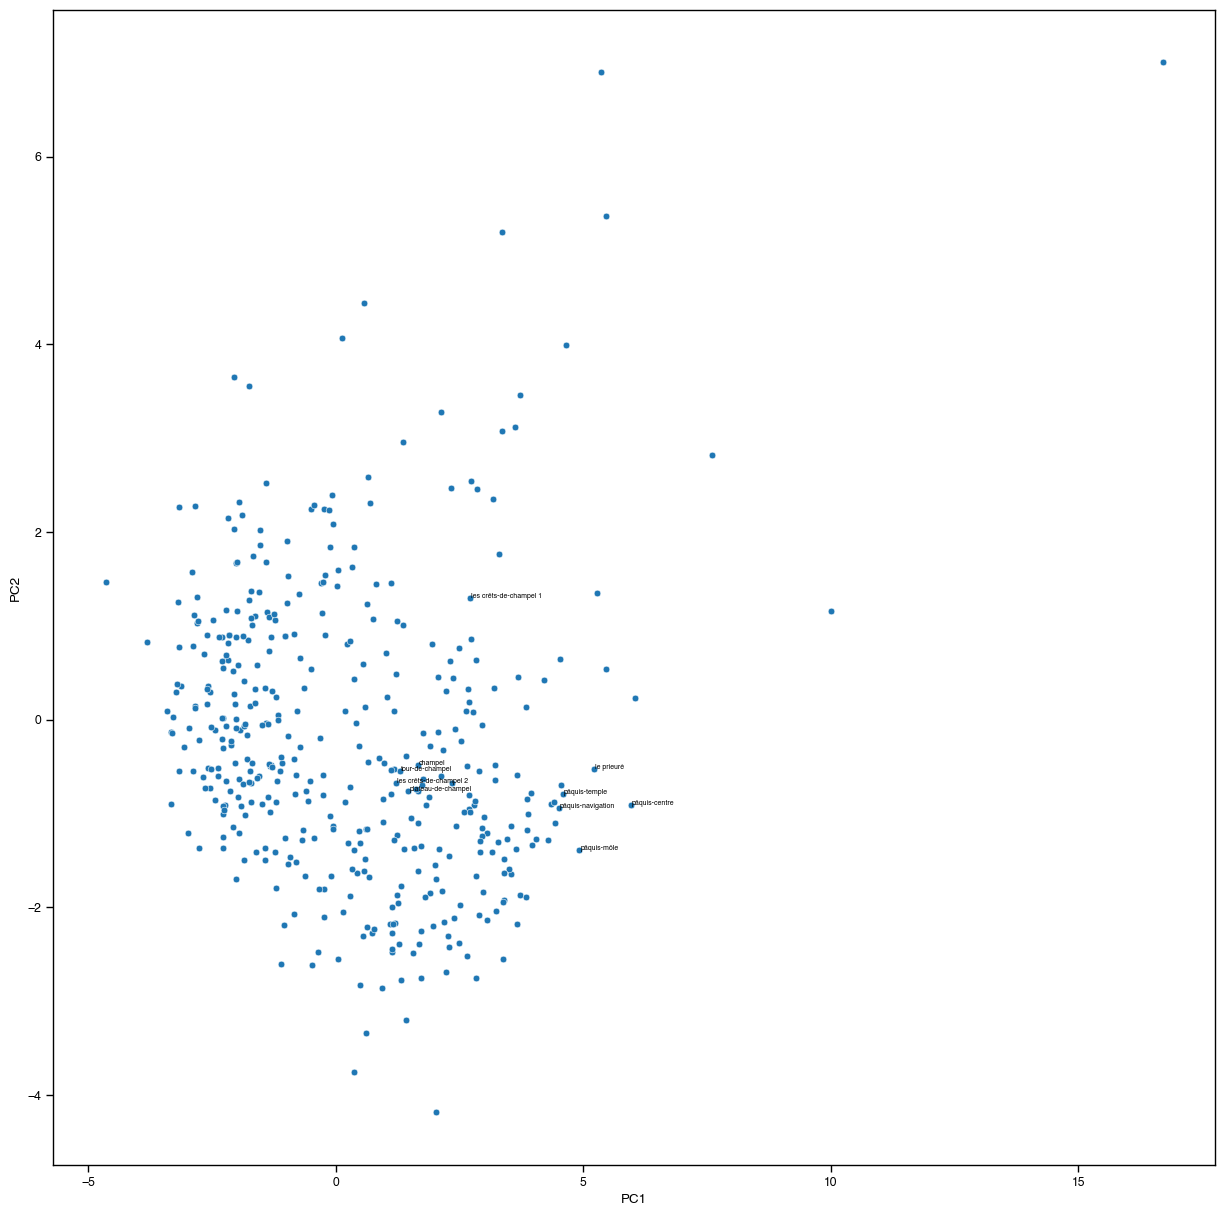

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))

sns.scatterplot(data = test, x = 'PC1', y= 'PC2')
label_point(test[test.NOM.str.contains('champel|pâquis|prieuré')].PC1, test[test.NOM.str.contains('champel|pâquis|prieuré')].PC2, classes_mean_girecs.NOM, plt.gca())  


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

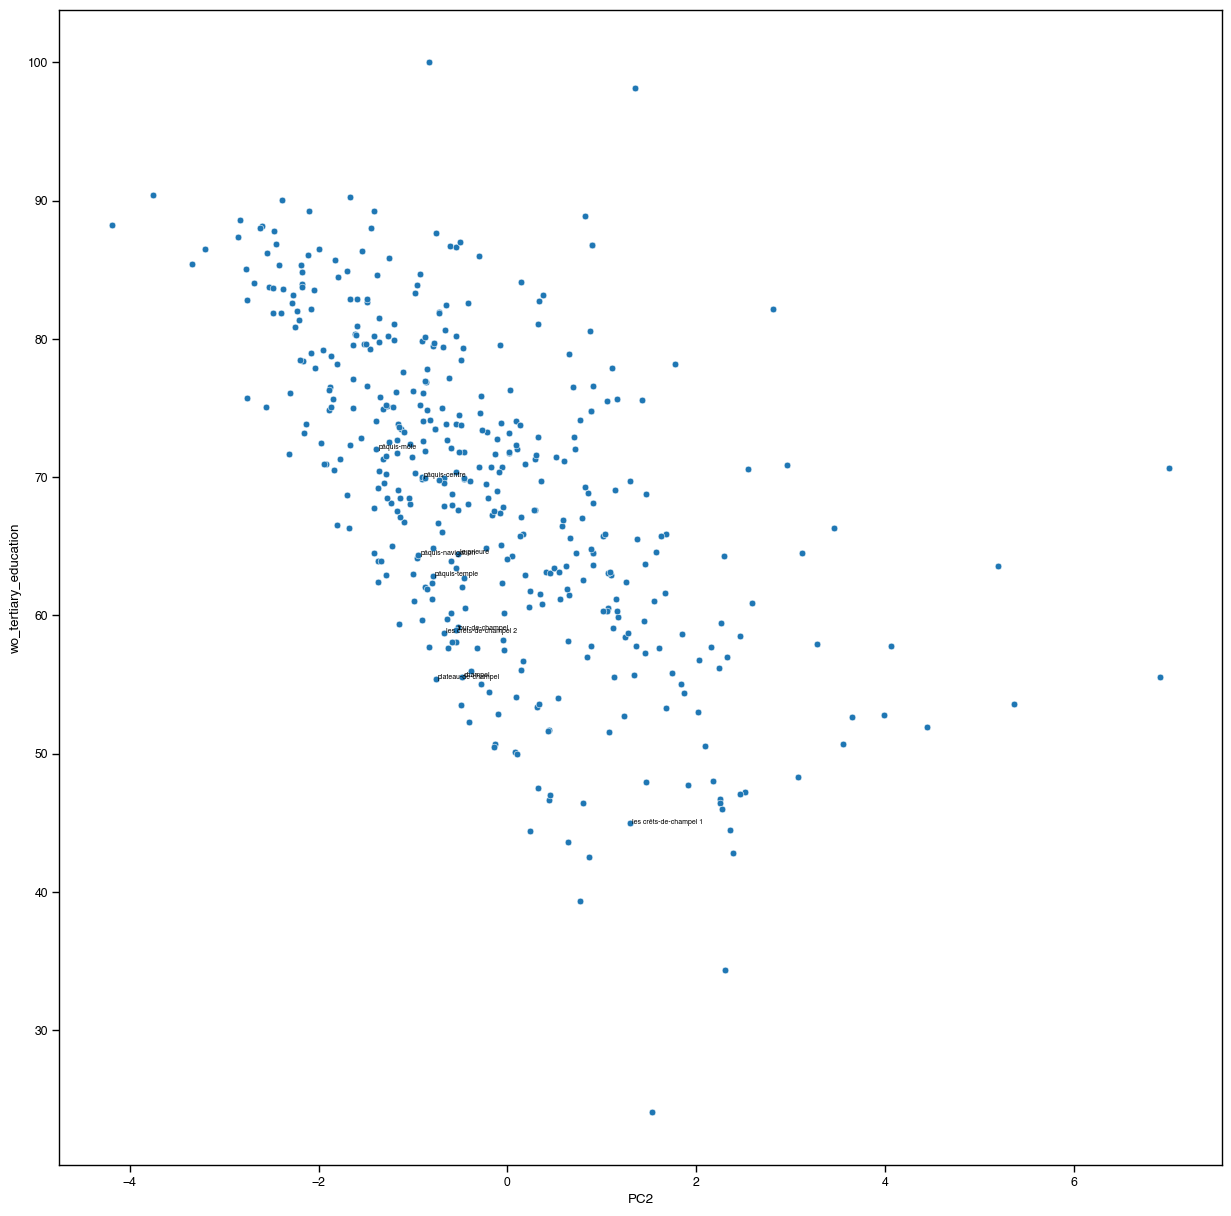

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))

sns.scatterplot(data = test, x = 'PC2', y= 'wo_tertiary_education')
label_point(test[test.NOM.str.contains('champel|pâquis|prieuré')].PC2, test[test.NOM.str.contains('champel|pâquis|prieuré')].wo_tertiary_education, classes_mean_girecs.NOM, plt.gca())  


In [ ]:
import matplotlib.patches as mpatches

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = classes_mean, x = 'PC1', y= 'PC2',hue = 'class_emergent_getis', s=100, palette = colors_cl_getis_en, ax = ax)
plt.legend(title='Classes', loc='upper left')

# sns.scatterplot(data = classes_mean_paquis, x = 'PC1',y = 'PC2', palette = {'Pâquis':'Green'}, hue = 'NOM', style = 'NOM', s = 150, ax = ax)
sns.scatterplot(data = classes_mean_girecs, x = 'PC1',y = 'PC2', s = 10, hue = 'max_class',palette = colors_cl_getis_en, markers = '*', legend = False,ax = ax)
# sns.regplot(data = classes_mean_girecs[classes_mean_girecs.max_class.str.contains('chaud', na = False)], x = 'PC1',y = 'PC2',color = 'red',scatter = False,ax = ax)
# sns.regplot(data = classes_mean_girecs[classes_mean_girecs.max_class.str.contains('froid', na = False)], x = 'PC1',y = 'PC2',color = 'blue',scatter = False,ax = ax)
abline(0, 0)
avline(0, 0)
ax.annotate('Aisé',xy=(8,5.5))
ax.annotate('Urbain',xy=(8,5.2))
ax.annotate('Cosmopolite',xy=(8,4.9))
left, bottom, width, height = (7.8, 4.7, 1.8, 1.1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="grey",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)

ax.annotate('Précaire',xy=(8,-3))
ax.annotate('Urbain',xy=(8,-3.3))
ax.annotate('Cosmopolite',xy=(8,-3.6))
left, bottom, width, height = (7.8, -3.8, 1.8, 1.1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="grey",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
ax.annotate('Précaire',xy=(-4,-3))
ax.annotate('Rural/Périurbain',xy=(-4,-3.3))
ax.annotate('Faible pop. étrangère',xy=(-4,-3.6))
left, bottom, width, height = (-4.2, -3.8, 2.9, 1.1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="grey",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
ax.annotate('Aisé',xy=(-4,5.5))
ax.annotate('Rural/Périurbain',xy=(-4,5.2))
ax.annotate('Faible pop. étrangère',xy=(-4,4.9))
left, bottom, width, height = (-4.2, 4.7, 2.9, 1.1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="grey",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
# plt.legend([],[], frameon=False)
label_point(classes_mean_girecs.PC1, classes_mean_girecs.PC2, classes_mean_girecs.NOM, plt.gca())  

plt.xlabel(f"Première composante ({round(pca.explained_variance_ratio_[0]*100,1)}%)")
plt.ylabel(f"Première composante ({round(pca.explained_variance_ratio_[1]*100,1)}%)")
plt.savefig('../Results/PCA_emergent_geogirec_giracs_PC12.pdf',bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = classes_mean, x = 'PC1', y= 'PC3',hue = 'class_emergent_getis', s=100, palette = colors_cl_getis_en, ax = ax)
sns.scatterplot(data = classes_mean_paquis, x = 'PC1',y = 'PC3', palette = {'Pâquis':'Green'}, hue = 'NOM', style = 'NOM', s = 150, ax = ax)
sns.scatterplot(data = classes_mean_girecs, x = 'PC1',y = 'PC3', s = 5, hue = 'max_class',palette = colors_cl_getis_en, ax = ax)
# plt.legend([],[], frameon=False)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), size = 5)
label_point(classes_mean_girecs.PC1, classes_mean_girecs.PC3, classes_mean_girecs.NOM, plt.gca())  

plt.savefig('../Results/PCA_emergent_geogirec_giracs_PC13.pdf',bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = classes_mean, x = 'PC2', y= 'PC3',hue = 'class_emergent_getis', s=100, palette = colors_cl_getis_en, ax = ax)
sns.scatterplot(data = classes_mean_paquis, x = 'PC2',y = 'PC3', palette = {'Pâquis':'Green'}, hue = 'NOM', style = 'NOM', s = 150, ax = ax)
sns.scatterplot(data = classes_mean_girecs, x = 'PC2',y = 'PC3', hue = 'max_class',palette = colors_cl_getis_en, s = 5, ax = ax)
# plt.legend([],[], frameon=False)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), size = 5)
label_point(classes_mean_girecs.PC2, classes_mean_girecs.PC3, classes_mean_girecs.NOM, plt.gca())  

plt.savefig('../Results/PCA_emergent_geogirec_giracs_PC23.pdf',bbox_inches = 'tight')

In [ ]:
df_carte_interactive = df_comparison_emergent_getis[['ebs_rate','class_emergent_getis','geometry']]

In [ ]:
df_carte_interactive['ebs_rate'] = df_carte_interactive['ebs_rate'].round(1)
df_carte_interactive.columns = ['Taux de participation lissé (%)','Classe','geometry']

In [ ]:
m = df_carte_interactive.explore('Classe', cmap = hmap)
m.save('../Manuscript/Carte interactive - Analyse spatiotemporelle.html')

In [ ]:
m

## Modelling

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
old_names = ['ciqmd','center_density','center_nearest','deprivation_pca','dmdrent','wo_tertiary_education','rpnch','radune',"B20BTOT",'rad3tert',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '70-74',]

new_names = ['Median income (CHF)','Centre density','Nearest centre','SES deprivation','Median monthly rent (CHF)','Tertiary education (%)','Swiss nationals (%)','Unemployment (%)',"Population count",'Tertiary sector (%)',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '70-74']

In [ ]:
dict_col_names = {k:v for k,v in zip(old_names,new_names)}

In [ ]:
dict_col_names['e'] = 'X-coord'
dict_col_names['n'] = 'Y-coord'
dict_col_names['ebs_rate'] = 'Participation rate (%)'

In [ ]:
df_comparison_emergent_getis['radune']

In [ ]:
df_modelling = df_comparison_emergent_getis.copy()
df_modelling.name = 'Participation'

In [ ]:
df_modelling['e'] = df_modelling.geometry.centroid.x
df_modelling['n'] = df_modelling.geometry.centroid.y

In [ ]:
df_modelling = df_modelling.rename(columns=dict_col_names)

In [ ]:
# df_modelling[X_eq0] = StandardScaler().fit_transform(df_modelling[X_eq0])

In [ ]:
%%time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 30, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.05),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 30, 1, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.3, 1.01, 0.05),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 1.01, 0.05)),
        'gamma': hp.quniform('gamma', 0.1, 5, 0.05),
    
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
    }

def score(params, n_folds=5):
    
    #Cross-validation
    d_train = xgboost.DMatrix(X_coords, y)
    
    cv_results = xgboost.cv(params, d_train, nfold = n_folds, num_boost_round=500,
                        early_stopping_rounds = 10, metrics = 'rmse', seed = 0)
    
    loss = min(cv_results['test-rmse-mean'])
    
    return loss

def optimize(trials, space, n_evals):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=n_evals,trials=trials,
                rstate=np.random.default_rng(333))#Add seed to fmin function
    return best

In [ ]:
def interpretable_ml_shap_viz_gpt(df, y_col, final_model, X_coords, explainer_shap, shap_values, model_directory, include_spatial):
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    shap_interaction_values = explainer_shap.shap_interaction_values(X_coords)
    # Shapley summary
    shap.summary_plot(shap_values, feature_names=X_coords.columns, show=False)
    plt.savefig(model_directory / 'shap_summary.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Shapley interaction values
    shap.summary_plot(shap_interaction_values, X_coords, max_display=16,
                      feature_names=X_coords.columns, show=False, plot_type="compact_dot")
    plt.savefig(model_directory / 'shap_summary_interaction_values.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Shapley dependence plots
    dependence_dir = model_directory / 'Dependence plots'
    if not os.path.exists(dependence_dir):
        os.makedirs(dependence_dir)
    
    for name in X_coords.columns:
        shap.dependence_plot(name, shap_values.values, X_coords, display_features=X_coords, show=False)
        plt.savefig(dependence_dir / f'shap_dependence_{name}.png', dpi=300, bbox_inches='tight')
        plt.close()

    # Calculate the number of rows and columns for the subplots
    n_columns = len(X_coords.columns)
    n_rows = int(np.ceil(n_columns / 3))

    # Maps of SHAP variables
    if include_spatial:
        fig, ax = plt.subplots(n_rows, 3, figsize=(15, 15 * n_rows / 3))
        ax = ax.ravel()

        for j in range(n_columns):
            df.plot(ax=ax[j], column=shap_values.values[:, j], legend=True,
                    vmin=-0.8, vmax=0.8, cmap=shap.plots.colors.red_white_blue, legend_kwds={'shrink':0.5})
            ax[j].set_title("SHAP for\n" + str(X_coords.columns[j]), fontsize=10)
            ax[j].set_axis_off()

        # Hide remaining unused subplots
        for j in range(n_columns, n_rows * 3):
            ax[j].set_axis_off()

        plt.tight_layout()
        plt.savefig(model_directory / 'maps_shap_variables.png', dpi=300, bbox_inches='tight')
        plt.close()

        # Map of location effects
        fig, ax = plt.subplots(dpi=300)

        df.plot(ax=ax, column=shap_values.values[:, -1] + shap_values.values[:, -2],
                legend=True, vmin=-0.6, vmax=0.6, figsize=(15, 8),
                cmap=shap.plots.colors.red_white_blue)
        plt.title("Location Effect on Cluster persistence\n(SHAP values of geographic coordinates)\n", fontsize=8)
        plt.axis('off')
        plt.savefig(model_directory/ 'maps_shap_location.png', dpi=300, bbox_inches='tight')
        plt.close()

    # Variable importance
    xgboost.plot_importance(final_model)
    plt.title("xgboost.plot_importance(final_model)")
    plt.savefig(model_directory / 'importance_plot_default.png', dpi=300, bbox_inches='tight')
    plt.close()

    xgboost.plot_importance(final_model, importance_type="cover")
    plt.title('xgboost.plot_importance(final_model, importance_type="cover")')
    plt.savefig(model_directory / 'importance_plot_cover.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Force plots
    shap.force_plot(explainer_shap.expected_value, shap_values.values[1, :], X_coords.iloc[1, :], show=False, matplotlib=True)
    plt.savefig(model_directory / 'force_plot.png', dpi=300, bbox_inches='tight')
    plt.close()
    return df

def train_xgboost(gwr_df, X_eq, y_col, optimize, space, n_evals, file_prefix, include_spatial=True, plot_figures=True):
    df_model = gwr_df.copy(deep = True)
    model_directory = res_folder / 'Modelling' / file_prefix
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    if include_spatial:
        X_coords = df_model[X_eq + ['X-coord', 'Y-coord']]
    else:
        X_coords = df_model[X_eq]
    y = df_model[y_col]
#     print(X_coords.columns)
    X_train, X_test, y_train, y_test = train_test_split(X_coords, y, 
                                                        test_size=0.2, 
                                                        random_state=0)
    
    ### Hyperparameter tuning
    if not os.path.exists(model_directory/'best_params.pkl'):

        trials = Trials()
        best_params = optimize(trials, space, n_evals=n_evals)

        # Return the best parameters
        best_params = space_eval(space, best_params)

        with open(model_directory / 'trials.pkl', 'wb') as f:
            pickle.dump(trials, f)

        with open(model_directory / 'best_params.pkl', 'wb') as f:
            pickle.dump(best_params, f)
    else:
        best_params = np.load(model_directory / 'best_params.pkl', allow_pickle=True)

        with open(model_directory/ 'trials.pkl', 'rb') as f:
            trials = pickle.load(f)

    ### Train model
    d_train = xgboost.DMatrix(X_train, label=y_train)
    d_test = xgboost.DMatrix(X_test, label=y_test)
    d_all = xgboost.DMatrix(X_coords, label=y)

    final_model = xgboost.train(best_params,  d_train, num_boost_round=500, evals=[(d_train, "train"), (d_test, "test")], 
                                verbose_eval=False, early_stopping_rounds=10)

    y_pred_t = final_model.predict(d_test)

    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_t)))
    print("R2:", r2_score(y_test, y_pred_t))

    data_test = xgboost.DMatrix(X_test, y_test)
    data = xgboost.DMatrix(X_train, y_train)
    
    if not os.path.exists(model_directory/'model.pkl'):

        final_model = xgboost.train(best_params, data, num_boost_round=5000, verbose_eval=False,
                                evals=[(data_test, "Test")], early_stopping_rounds=10)
        with open(model_directory/'model.pkl', 'wb') as f:
            pickle.dump(final_model, f)
    else:
        final_model = np.load(model_directory / 'model.pkl', allow_pickle=True)

    data_all = xgboost.DMatrix(X_coords)
    y_pred = final_model.predict(data_all)
    print('RMSE:', np.sqrt(mean_squared_error(y, y_pred)))
    print('R2: ', r2_score(y, y_pred))
    
    explainer_shap = shap.TreeExplainer(final_model)
    shap_values = explainer_shap(X_coords)
    f0_est = df_model[y_col].mean() + shap_values.values[:,len(X_coords)-2:].sum(axis=1) 
    df_model['shap_values_pred'] = f0_est
    df_model['pred'] = y_pred
    df_model['residuals'] = df_model[y_col] - df_model['pred']
    if plot_figures:
        df_model = interpretable_ml_shap_viz_gpt(df_model, y_col, final_model, X_coords, explainer_shap, shap_values, model_directory, include_spatial)

    return final_model, df_model, shap_values

In [ ]:
y = 'Participation rate (%)'
X_eq0 = ['Median income (CHF)','Centre density','Median monthly rent (CHF)','Tertiary education (%)','Unemployment (%)','Tertiary sector (%)','Swiss nationals (%)',"Population count",
 '50-54','55-59','60-64','65-69','70-74']
X_eq1 = ['SES deprivation','Centre density']
X_eq2 = ['SES deprivation']
X_eq3 = ['Centre density']
X_eq4 = ['Nearest centre']

Xs = [X_eq0, X_eq1, X_eq2, X_eq3]

In [ ]:
X_coords = df_modelling[X_eq0 + ['X-coord','Y-coord']]
include_spatial = True
y_col = 'Participation rate (%)'
n_evals = 200
df_model = df_modelling.copy(deep = True)
model_directory = res_folder / 'Modelling' / 'Model 0'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
if include_spatial:
    X_coords = df_model[X_eq0 + ['X-coord', 'Y-coord']]
else:
    X_coords = df_model[X_eq0]
y = df_model[y_col]
#     print(X_coords.columns)
X_train, X_test, y_train, y_test = train_test_split(X_coords, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

### Hyperparameter tuning
if not os.path.exists(model_directory/'best_params.pkl'):

    trials = Trials()
    best_params = optimize(trials, space, n_evals=n_evals)

    # Return the best parameters
    best_params = space_eval(space, best_params)

    with open(model_directory / 'trials.pkl', 'wb') as f:
        pickle.dump(trials, f)

    with open(model_directory / 'best_params.pkl', 'wb') as f:
        pickle.dump(best_params, f)
else:
    best_params = np.load(model_directory / 'best_params.pkl', allow_pickle=True)

    with open(model_directory/ 'trials.pkl', 'rb') as f:
        trials = pickle.load(f)

### Train model
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
d_all = xgboost.DMatrix(X_coords, label=y)

final_model = xgboost.train(best_params,  d_train, num_boost_round=500, evals=[(d_train, "train"), (d_test, "test")], 
                            verbose_eval=False, early_stopping_rounds=10)

y_pred_t = final_model.predict(d_test)


In [ ]:
X_coords = df_modelling[X_eq0 + ['X-coord','Y-coord']]
model0, gwr_df_model0, shap_values_model0 = train_xgboost(df_modelling, X_eq0, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 0',include_spatial=True, plot_figures = True)
X_coords = df_modelling[X_eq1 + ['X-coord','Y-coord']]
model1, gwr_df_model1, shap_values_model1 = train_xgboost(df_modelling, X_eq1, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 1',include_spatial=True, plot_figures = True)
X_coords = df_modelling[X_eq2 + ['X-coord','Y-coord']]
model2, gwr_df_model2, shap_values_model2 = train_xgboost(df_modelling, X_eq2, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 2',include_spatial=True, plot_figures = True)
X_coords = df_modelling[X_eq3 + ['X-coord','Y-coord']]
model3, gwr_df_model3, shap_values_model3 = train_xgboost(df_modelling, X_eq3, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 3',include_spatial=True, plot_figures = True)
X_coords = df_modelling[X_eq4]
model4, gwr_df_model4, shap_values_model4 = train_xgboost(df_modelling, X_eq4, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 4',include_spatial=True, plot_figures = True)
X_coords = df_modelling[X_eq2]
model2_bis, gwr_df_model2_bis, shap_values_model2_bis = train_xgboost(df_modelling, X_eq2, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 2 - Not spatial',include_spatial=False, plot_figures = True)
X_coords = df_modelling[X_eq3]
model3_bis, gwr_df_model3_bis, shap_values_model3_bis = train_xgboost(df_modelling, X_eq3, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 3 - Not spatial',include_spatial=False, plot_figures = True)
X_coords = df_modelling[X_eq4]
model4_bis, gwr_df_model4_bis, shap_values_model4_bis = train_xgboost(df_modelling, X_eq4, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model 4 - Not spatial',include_spatial=False, plot_figures = True)

In [ ]:
reload(pyspace)

In [ ]:
for i, adjusted_df in enumerate([gwr_df_model0, gwr_df_model1, gwr_df_model2, gwr_df_model3, gwr_df_model4, gwr_df_model2_bis, gwr_df_model3_bis, gwr_df_model4_bis]):
    wnn16 = lps.weights.KNN(cKDTree(get_points_array(adjusted_df.geometry.centroid)),16)
    adjusted_df['residuals_scaled'] = minmax_scale(adjusted_df['residuals'], feature_range = (0,100))
    getiswnn16 = pyspace.compute_getis(adjusted_df,'residuals_scaled',wnn16, 9999,'b', p_001=True)
    fdr_pvalue = fdr(getiswnn16.p_sim, 0.05)
    adjusted_df['residuals_scaled_G_cl_fdr'] = adjusted_df['residuals_scaled_G_cl']  
    adjusted_df.loc[adjusted_df['residuals_scaled_G_psim'] >= fdr_pvalue, 'residuals_scaled_G_cl_fdr'] = '0 Non-Significant'
    fig, ax = pyspace.plotGetisMap(adjusted_df,'residuals_scaled_G_cl',p_001 = True, commune_name = False)
    filename = 'getis_giracs_ha_adjusted_xgboost_wnn16_005_model%s.png' % (str(i))
    plt.savefig(figures_folder/filename,dpi = 300, bbox_inches = 'tight')
    plt.show()

### All periods

In [ ]:
models = {}

In [ ]:
# df['index_socio_pca'] = df['RELI'].map(reli_deprivation)
# df['ciqmd'] = df['RELI'].map(reli_ciqmd)
# df['center_density'] = df['RELI'].map(reli_center_density)
# df = df.set_index("RELI")
# df = pd.merge(df,df_sociodemo_access_RELI, left_index = True, right_index = True)
# df['rpam'] = df.filter(regex = 'cam|nam|sam').sum(axis = 1)
# df['rpaf'] = df.filter(regex = 'af').sum(axis = 1)
# df['rpas'] = df.filter(regex = 'cas|sas|seas|rpnme').sum(axis = 1)
# df['rpeu'] = df.filter(regex = 'ceu|weu|neu|eeu').sum(axis = 1)
# df['e'] = df.geometry.centroid.x
# df['n'] = df.geometry.centroid.y
# df = df.rename(columns=dict_col_names)
# X_coords = df[X + ['X-coord','Y-coord']]
# y = df['Participation rate (%)']
# return df, X_coords, y

In [ ]:
def preprocess_dataframe(df, reli_deprivation, reli_ciqmd, reli_center_density, dict_col_names, X):
    df['index_socio_pca'] = df['RELI'].map(reli_deprivation)
    df['ciqmd'] = df['RELI'].map(reli_ciqmd)
    df['center_density'] = df['RELI'].map(reli_center_density)
    df = df.set_index("RELI")
    df = pd.merge(df,df_sociodemo_access_RELI, left_index = True, right_index = True)
    df['rpam'] = df.filter(regex = 'cam|nam|sam').sum(axis = 1)
    df['rpaf'] = df.filter(regex = 'af').sum(axis = 1)
    df['rpas'] = df.filter(regex = 'cas|sas|seas|rpnme').sum(axis = 1)
    df['rpeu'] = df.filter(regex = 'ceu|weu|neu|eeu').sum(axis = 1)
    df['e'] = df.geometry.centroid.x
    df['n'] = df.geometry.centroid.y
    df = df.rename(columns=dict_col_names)
    X_coords = df[X + ['X-coord','Y-coord']]
    y = df['Participation rate (%)']
    return df, X_coords, y

def create_model_for_each_year(dfs_year, reli_deprivation, reli_ciqmd, reli_center_density, dict_col_names, X, optimize, space):
    models = {}
    for i, df_year in enumerate(dfs_year):
        year = BASE_YEAR + i*YEAR_INTERVAL
        df_year, X_coords, y = preprocess_dataframe(df_year, reli_deprivation, reli_ciqmd, reli_center_density, dict_col_names, X)
        _model, _gwr_df, _shap_values = train_xgboost(df_year, X, 'Participation rate (%)', optimize, space, n_evals=NUMBER_OF_EVALUATIONS, file_prefix='Model {} - {}'.format(i, year))
        results = [_model, _gwr_df, _shap_values]
        models[year] = results
    return models

# Constants
BASE_YEAR = 2000
YEAR_INTERVAL = 2
NUMBER_OF_EVALUATIONS = 200

# all_models = []
# for i, X in enumerate(Xs):
#     all_models.append(create_model_for_each_year(dfs_year, reli_deprivation, reli_ciqmd, reli_center_density, dict_col_names, X, optimize, space))


In [ ]:
# scaler = StandardScaler()
# for i, X in enumerate(Xs):
#     models[i] = {}
#     for j, df_year in enumerate(dfs_year):
#         year = 2000 + j*2
#         df_year['index_socio_pca'] = df_year['RELI'].map(reli_deprivation)
#         df_year['ciqmd'] = df_year['RELI'].map(reli_ciqmd)
#         df_year['center_density'] = df_year['RELI'].map(reli_center_density) ## WARNING THIS WON'T INCLUDE CHANGES IN ACCESS OVER TIME
#         df_year = df_year.set_index("RELI")
#         df_year = pd.merge(df_year,df_sociodemo_access_RELI, left_index = True, right_index = True)
#         df_year['rpam'] = df_year.filter(regex = 'cam|nam|sam').sum(axis = 1)
#         df_year['rpaf'] = df_year.filter(regex = 'af').sum(axis = 1)
#         df_year['rpas'] = df_year.filter(regex = 'cas|sas|seas|rpnme').sum(axis = 1)
#         df_year['rpeu'] = df_year.filter(regex = 'ceu|weu|neu|eeu').sum(axis = 1)
#         df_year['e'] = df_year.geometry.centroid.x
#         df_year['n'] = df_year.geometry.centroid.y
#         df_year = df_year.rename(columns=dict_col_names)
#         X_coords = df_year[X + ['X-coord','Y-coord']]
#         y = df_year['Participation rate (%)']
#         _model, _gwr_df, _shap_values = train_xgboost(df_year, names, 'Participation rate (%)', optimize, space, n_evals=200, file_prefix='Model {} - {}'.format(i, year))
#         results = [_model, _gwr_df, _shap_values]
#         models[i][year] = results

In [ ]:
year = 2002
i = 1
for i in range(1,11):
    df_year = models[i][1]
    wnn16 = lps.weights.KNN(cKDTree(get_points_array(df_year.geometry.centroid)),16)
    df_year['residuals_scaled'] = minmax_scale(df_year['residuals'], feature_range = (0,100))
    getiswnn16 = pyspace.compute_getis(df_year,'residuals_scaled',wnn16, 9999,'b')
    fdr_pvalue = fdr(getiswnn16.p_sim, 0.05)
    df_year['residuals_scaled_G_cl_fdr'] = df_year['residuals_scaled_G_cl']  
    df_year.loc[df_year['residuals_scaled_G_psim'] >= fdr_pvalue, 'residuals_scaled_G_cl_fdr'] = '0 Non-Significant'
    fig, ax = pyspace.plotGetisMap(df_year,'residuals_scaled_G_cl',p_001 = False, commune_name = False)
    ax.set_title(year)
    filename = 'getis_giracs_ha_adjusted_xgboost_wnn16_005_%s.png' % (str(year))
    plt.savefig(res_folder/'Getis'/filename,dpi = 300, bbox_inches = 'tight')
    year+=2

In [ ]:
keys = sorted(models.keys())

# Exclude the first key from your list
keys = keys[1:]
df_list = [models[k][1][['year_invit','residuals_scaled_G_Zs','residuals_scaled_G_cl_fdr','residuals_scaled_G_psim','residuals_scaled_G_cl','geometry']].reset_index() for k in keys]  # Extract the second item from each list in the dictionary
df_space_time_cube_xgboost = pd.concat(df_list, ignore_index=True)

In [ ]:
df_space_time_cube_xgboost['time'] = df_space_time_cube_xgboost['year_invit'].astype(int).sub(2002).div(2)

In [ ]:
df_emergent_getis_xgboost = spatiotemporal_getis_cats_prep(df_space_time_cube_xgboost,'residuals_scaled_G_cl','residuals_scaled_G_Zs', 9)

In [ ]:
df_emergent_getis_xgboost['geometry'] = df_ha['geometry']

df_emergent_getis_xgboost['class'] = translate_cat(df_emergent_getis_xgboost['class'],'FR')

df_emergent_getis_xgboost = gpd.GeoDataFrame(df_emergent_getis_xgboost, crs = 2056, geometry = df_emergent_getis_xgboost['geometry'])

df_emergent_getis_xgboost['class_raw'] = df_emergent_getis['class']

In [ ]:
df_emergent_getis_xgboost[['class_raw','class']].groupby('class_raw')['class'].value_counts()

In [ ]:
hmap_adj = colors.ListedColormap([colors_cl_getis_en[i] for i in df_emergent_getis_xgboost['class'].sort_values().unique()])

ax = df_emergent_getis_xgboost.plot('class', cmap = hmap_adj, figsize = (12,12), zorder = 3, linewidth = 0.01, legend = True, legend_kwds = {'title':'Categories','fontsize':10})
communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
ax.set_axis_off()
plt.savefig('../Results/Emergent Getis/Full_picture - Adjusted XGBoost.png', dpi = 1200, bbox_inches = 'tight')
plt.show()

### Interpretation

In [ ]:
%matplotlib inline

In [ ]:
gwr_df_model1.plot('residuals',categorical=True, scheme='equalinterval', linewidth = 0.01, cmap = 'viridis',legend = True, figsize = (10, 10))

In [ ]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
X_coords = df_modelling[X_eq0 + ['X-coord','Y-coord']]
explainer = shap.TreeExplainer(model0)
shap_values = explainer.shap_values(X_coords)
shap_interaction_values = explainer.shap_interaction_values(X_coords)

In [ ]:
shap.summary_plot(shap_values, X_coords, plot_type="bar")

In [ ]:
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[2,:], X_coords.iloc[2,:])

In [ ]:
shap.summary_plot(shap_interaction_values, X_coords, feature_names=X_coords.columns, plot_type = 'compact_dot')

In [ ]:
shap.summary_plot(shap_values, X_coords, plot_type="violin")

In [ ]:
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[:2000,:], X_coords.iloc[:2000,:])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values)
shap_embedded = TSNE(n_components=2, perplexity=30).fit_transform(shap_values)

In [ ]:
import matplotlib as mpl
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = mpl.colors.LinearSegmentedColormap('RedBlue', cdict1)

In [ ]:
f = plt.figure(figsize=(10,10))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values.sum(1).astype(np.float64),
           linewidth=0, alpha=1., s=10, cmap=red_blue_solid)
cb = plt.colorbar(label="Participation", aspect=40, orientation="horizontal")
cb.set_alpha(1)
# cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
for feature in ['Centre density','Median income (CHF)','Tertiary education (%)','Population count','Unemployment (%)','X-coord','Y-coord']:
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X_coords[feature].values.astype(np.float64),
               linewidth=0, alpha=.8, s = 4, cmap=red_blue_solid)
    cb = plt.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
#     plt.gca().axis("off")
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50_3d = PCA(n_components=12).fit_transform(shap_values)
shap_embedded_3d = TSNE(n_components=3, perplexity=30).fit_transform(shap_values)

In [ ]:
for feature in ['Centre density','Median income (CHF)','Tertiary education (%)','X-coord','Y-coord']:
    f = plt.figure(figsize=(8,8))
    ax = f.add_subplot(111, projection='3d')
    img = ax.scatter(shap_embedded_3d[:,0], shap_embedded_3d[:,1], shap_embedded_3d[:,2], 
                     c=X_coords[feature].values.astype(np.float64), 
                     cmap=red_blue_solid, alpha=.8, s = 3)
    cb = plt.colorbar(img, label=feature, aspect=30, orientation="horizontal")
    cb.set_alpha(1)
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
#     ax.set_axis_off()
    plt.show()


## Hierarchical clustering

In [ ]:
geo_girec_hc = pd.merge(geo_girec, mean_params_nom[['NOM','gp_hc']], on = 'NOM')

In [ ]:
mean_params_nom['gp_hc'] = mean_params_nom['gp_hc'].astype(str)

In [ ]:
geo_girec_hc.explore('gp_hc')

In [ ]:
m = df_emergent_getis.explore('class', cmap = hmap)
geo_girec_hc.explore('gp_hc',m = m)

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
sns.scatterplot(data = mean_params_nom, x = 'ciqmd', y= 'dmdrent', hue = 'gp_hc', style = 'gp_hc', ax = ax)
label_point(mean_params_nom_paquis.ciqmd, mean_params_nom_paquis.dmdrent, mean_params_nom_paquis.NOM, plt.gca())  

In [ ]:
# test.set_index('NOM')

In [ ]:
test['gp_hc'] = test['NOM'].map(mean_params_nom.set_index('NOM')['gp_hc'].to_dict())

In [ ]:
mean_params_nom.groupby('gp_hc').mean().ciqmd.plot.bar()

In [ ]:
mean_params_nom.groupby('gp_hc').mean().rpnch.plot.bar()

In [ ]:
test[(test.year_invit_2y == '2020')].groupby('gp_hc').mammo.mean()

In [ ]:
gp_paquis = test[(test.gp_hc.isin(['5']))&(test.year_invit_2y == '2020')]

In [ ]:
gp_paquis.groupby('NOM')['ciqmd'].mean().sort_values().plot.bar()

### Decision tree

In [ ]:
mean_params_nom.columns

In [ ]:
feature_cols = ['ciqmd', 'ptot', 'center_nearest', 'rpnoce', 'rpncam', 'rpncas',
       'rpnceu', 'rpneeu', 'rpneceu', 'rpnfe', 'rpnme', 'rpnnaf', 'rpnnam',
       'rpnneu', 'rpnnweu', 'rpnsam', 'rpnsas', 'rpnseas', 'rpnseeu',
       'rpnsweu', 'rpnsubaf', 'rpnweu', 'rad3sec', 'rad3tert', 'rprprot',
       'rprcath', 'rprochr', 'rprjew', 'rprmusl', 'rproth', 'rprnorel',
       'center_density', 'deprivation_pca', 'rpnch',
       'wo_tertiary_education', 'dmdrent', 'rp65+', 'rphh3p+']
X = mean_params_nom[feature_cols] # Features
y = mean_params_nom.gp_hc 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)


In [ ]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1','2','3','4','5','6','7','8','9'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('HC_tree.png')
Image(graph.create_png())

In [ ]:
X_train

### Pourquoi cette zone "intensification de point chaud"?

In [ ]:
df_intensification_emergent = df_emergent_getis[df_emergent_getis['class'] == 'Intensification de point chaud']

In [ ]:
df_intensification_emergent

In [ ]:
df_intensification_hs = df_all_years[df_all_years.RELI.isin(df_intensification_emergent.index)]

In [ ]:
df_intensification_hs

## Legacy code

In [ ]:
with open('../Results/dfs_year.pkl','wb') as f:
    pickle.dump(dfs_year, f)

In [ ]:
df_ha['cumul_LISA_res'] = 0
df_ha['cumul_LISA_9909_res'] = 0
df_ha['cumul_LISA_1018_res'] = 0

df_ha['cumul_LISA_zscore_res'] = 0
df_ha['cumul_LISA_9909_zscore_res'] = 0
df_ha['cumul_LISA_1018_zscore_res'] = 0
for df_year in dfs_year:
    _dict = df_year.set_index('RELI')['ebs_rate_res_Zs'].to_dict()
    df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_res_cl'].isin(['1 High-High','4 High-Low'])].RELI),'cumul_LISA_res'] +=1
    df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_res_cl'].isin(['3 Low-Low','2 Low-High'])].RELI),'cumul_LISA_res'] -=1
    df_ha['cumul_LISA_zscore'] += df_ha['RELI'].map(_dict)
    if df_year.year_invit.astype(int).unique()[0] < 2010:
        df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_res_cl'].isin(['1 High-High','4 High-Low'])].RELI),'cumul_LISA_9909_res'] +=1
        df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_res_cl'].isin(['3 Low-Low','2 Low-High'])].RELI),'cumul_LISA_9909_res'] -=1
    if  df_year.year_invit.astype(int).unique()[0] > 2009 and df_year.year_invit.astype(int).unique()[0] < 2019:
        df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_res_cl'].isin(['1 High-High','4 High-Low'])].RELI),'cumul_LISA_1018_res'] +=1
        df_ha.loc[df_ha.RELI.isin(df_year[df_year['ebs_rate_res_cl'].isin(['3 Low-Low','2 Low-High'])].RELI),'cumul_LISA_1018_res'] -=1

In [ ]:
df_ha['cumul_LISA_res_q3'] = pd.qcut(df_ha['cumul_LISA_res'], 3)
dict_cumul_LISA_res_q3 = df_ha.set_index('RELI')['cumul_LISA_res_q3'].to_dict()
df_ebs_over_years['cumul_LISA_res_q3'] = df_ebs_over_years.RELI.map(dict_cumul_LISA_res_q3)

In [ ]:
df_heatmap = df_ebs_over_years.groupby(['cumul_LISA_res_q3','index_socio_q3']).mean().reset_index()
df_heatmap = df_heatmap.pivot(index = 'cumul_LISA_res_q3',columns = 'index_socio_q3', values = 'ebs_rate')
df_heatmap.columns = ['Low','Medium','High']
df_heatmap = df_heatmap.sort_values('cumul_LISA_res_q3', ascending = False)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
df_ha.plot('cumul_LISA_res', legend = True, cmap = 'bwr', ax = ax, zorder = 3, legend_kwds = {'label':'Cumulated LISA cluster score','shrink':0.5})
communes.plot(color = 'lightgrey', alpha = 0.6, ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
lake.apply(lambda x: ax.annotate(text=x.NOM, xy=x.geometry.centroid.coords[0], ha='center', size=12), axis=1)

ax.set_axis_off()

left, bottom, width, height = [0.2, 0.55, 0.14, 0.12]
ax2 = fig.add_axes([left, bottom, width, height])
sns.set_context("paper")
x_label = 'Deprivation'
y_label = 'Cumulated cluster score'
chart = sns.heatmap(df_heatmap, cmap = 'Blues', alpha = 0.8, cbar_kws={'label': 'Participation rate (%)'})
chart.set_xticklabels(chart.get_xticklabels(),size=8, rotation=0, horizontalalignment='center')
chart.set_yticklabels(chart.get_yticklabels(),color = 'white', size=0, rotation=0, horizontalalignment='right')

plt.tick_params(bottom = False, left = False)

chart.set_xlabel(x_label, size=10)
chart.set_ylabel(y_label, size=10)



plt.savefig('../Results/LISA - Hectares/Cumulated LISA/Biennial_LISA_cumulated_socioadj_wnn16_005.png', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../Results/LISA - Hectares/Cumulated LISA/Biennial_LISA_cumulated_socioadj_wnn16_005.pdf', bbox_inches = 'tight')

In [ ]:
df_ha.to_crs(21781).to_feather('20220130_df_giracs_ha.feather')

### Stability of participation over time among LISA classes

In [ ]:
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
# the size of A4 paper
g = sns.lineplot(data=df_all_years_2020ha.groupby(['year_invit','ebs_rate_cl']).mean().reset_index(), x="year_invit", y="ebs_rate", hue = 'ebs_rate_cl', palette = colors_cl, errorbar = ('ci', 95),ax = ax)
for l in g.lines:
    y = l.get_ydata()
    if len(y)>0:
        g.annotate(f'{y[-1]:.1f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color(), size = 12)
ax.set_xlabel('Date',labelpad = 10, size = 16)
ax.set_ylabel('Taux de vaccination (%)',labelpad = 10, size = 16)
plt.legend(prop={'size': 14})
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='y')
plt.title('Evolution du taux de participation au sein des clusters locaux (LISA) identifiés en 2020',size = 16)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
# the size of A4 paper
g = sns.lineplot(data=df_all_years_2020ha, x="year_invit", y="ebs_rate", hue = 'ebs_rate_cl', palette = colors_cl, errorbar = ('ci', 95),ax = ax)
for l in g.lines:
    y = l.get_ydata()
    if len(y)>0:
        g.annotate(f'{y[-1]:.1f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color(), size = 12)
ax.set_xlabel('Date',labelpad = 10, size = 16)
ax.set_ylabel('Taux de vaccination (%)',labelpad = 10, size = 16)
plt.legend(prop={'size': 14})
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='y')
plt.title('Evolution du taux de participation au sein des clusters locaux (LISA) identifiés en 2020',size = 16)

## HC

In [ ]:
cluster_result_folder = Path('../Results/Cluster analyses/')
if not os.path.exists(cluster_result_folder):
    os.makedirs(cluster_result_folder)

In [ ]:
ha_charac = []
for df_year in dfs_year:
    y_mean_by_ha = pd.DataFrame(pd.merge(gdf_participation_ha,df_year.drop('year_invit', axis = 1), on = 'RELI').groupby('RELI')[['year_invit','ptot','ciqmd','center_density','center_nearest','deprivation_pca','50-54','55-59','60-64','65-69','70-74','75-79','80-84']].mean()).reset_index()
    y_mean_by_ha['geometry'] = y_mean_by_ha['RELI'].map(df_year[['RELI','geometry']].set_index('RELI').to_dict()['geometry'])
    ha_charac.append(y_mean_by_ha)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
has_hcs = []

for has in ha_charac:
    X = has.iloc[:,1:13].values
    hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
    y_hc = hc.fit_predict(X)
    has = has.assign(gp_hc = y_hc)
    has_hcs.append(has)

In [ ]:
def plot_hc(clusters,df,col,period):
    fig, ax = plt.subplots(1, figsize=(15, 15))
    hmap = colors.ListedColormap(['#2166ac','#67a9cf','#d1e5f0','#b2182b','#ef8a62','#fddbc7','#f7f7f7'])
    communes.plot(ax = ax, label='Communes',alpha = 0.3,color=None,edgecolor='black',facecolor='grey')
    communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center',size = 7),axis=1);
    
    lake.plot(ax = ax, label='Lake',alpha = 1,color = 'lightblue',edgecolor='None')
#     df.plot(col,cmap=hmap,markersize = 3,alpha = 0.4,ax = ax,categorical=True)
    hmap = colors.ListedColormap(['#beaed4','#fdc086','#7fc97f'])
    ##plot
    df_high = df[df[col].isin(['1 High-High','4 High-Low'])]
    df_low = df[df[col].isin(['3 Low-Low','2 Low-High'])]

    df_low.plot('gp_hc',cmap = hmap,ax = ax,alpha = 1,categorical = True,edgecolor='blue',linewidth=0.2)
    df_high.plot('gp_hc',cmap = hmap,ax = ax,alpha = 1,categorical = True,edgecolor='red',linewidth=0.2)

#     chulls_cold.plot(ax = ax,color = 'blue',alpha = 0.4,edgecolor='None')
#     hmap = colors.ListedColormap(['#fdbf6f','#cab2d6', '#ffffb3','#f03b20'])
#     ashapes_hc_hot.plot('gp_hc',cmap = hmap,ax = ax,alpha = 0.6,categorical = True,edgecolor='red',linewidth=1.4)
#     chulls_hot.plot(ax = ax,color = 'red',alpha = 0.4,edgecolor='None')
#     ashapes_hc_cold.apply(lambda x: ax.annotate(text=x['desc'], xy=x.geometry.centroid.coords[0], ha='center',size = 8),axis=1);
#     ashapes_hc_hot.apply(lambda x: ax.annotate(text=x['desc'], xy=x.geometry.centroid.coords[0], ha='center',size = 8),axis=1);

    ax.set_facecolor('grey')
    ax.set_axis_off()
    filename = "Getis Clusters Alpha Shapes with HC - {} - {}.pdf".format('HA - Mammo',period)
    plt.title(period)
    plt.savefig(cluster_result_folder/filename, dpi = 300,bbox_inches = 'tight')
    return fig, ax



In [ ]:
len(dfs_year)

In [ ]:
for ha_hc, df_year in zip(has_hcs, dfs_year):
    print(df_year.year_invit.unique()[0])
    ha_hc = gpd.GeoDataFrame(ha_hc, crs = 2056, geometry = ha_hc['geometry'])
    df_year['gp_hc'] = df_year.RELI.map(ha_hc[['RELI','gp_hc']].set_index('RELI').to_dict()['gp_hc'])
    plot_hc(ha_hc,df_year,'ebs_rate_cl', df_year.year_invit.unique()[0])

In [ ]:
dfs_year[10].plot('gp_hc', legend = True, categorical = True)

In [ ]:
has_hcs[10].groupby(['gp_hc'])[['ciqmd','deprivation_pca','center_nearest','ptot']].mean().round(1).sort_values('ciqmd')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
X = df_year.iloc[:,4:].values
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
try:
    y_hc_Cold = hc.fit_predict(X_cold)
    y_hc_Hot = hc.fit_predict(X_hot)

    ashape_cold = ashape_cold.assign(gp_hc = y_hc_Cold)
    ashape_hot = ashape_hot.assign(gp_hc = y_hc_Hot)
    ashape_hc = pd.concat([ashape_hot,ashape_cold])
    ashape_hcs.append(ashape_hc)
except:
    pass

# Spatial panel model

### Define list of hectares present in all years

In [ ]:
test = n_invit_by_ha.drop(['2000','2002','2004','2006'], axis = 1)

In [ ]:
test = test.set_index('RELI')

In [ ]:
n_invit_by_ha

In [ ]:
year = 2000
for df in dfs_year:
    df = df.set_index('RELI')
    print(year)
    colname = 'PR'+ str(year)
    test[colname] = df['ebs_rate']
    year += 2

In [ ]:
test

In [ ]:
dfs_year

In [ ]:
test = test.drop(['PR2000','PR2002','PR2004','PR2006'], axis = 1)

In [ ]:
PR_ = test[test>0].filter(regex = 'PR').dropna()
PR_ = PR_.fillna(0)

In [ ]:
# Define dependent variable
name_y = [ "PR2008","PR2010","PR2012","PR2014","PR2016","PR2018","PR2020"]
y = np.array([PR_[name] for name in name_y]).T


In [ ]:
name_x = ['Intercept2008','Intercept2010','Intercept2012','Intercept2014','Intercept2016','Intercept2018','Intercept2020']
x = np.array([np.random.normal(3,2.5,size = (4195)) for name in name_x]).T

In [ ]:
w = lps.weights.KNN.from_dataframe(df_ha[df_ha.RELI.isin(test[test>0].dropna().index)], k = 24)

In [ ]:
fe_lag = spreg.Panel_FE_Lag(
    y, x, w, name_y=name_y, name_x=name_x, name_ds="NAT")

In [ ]:
pickle.dump(fe_lag, open('../Results/panel_model.pkl', 'wb'))

In [ ]:
with open('../Results/panel_model.pkl', 'rb') as f:
    fe_lag = pickle.load(f)

In [ ]:
print(fe_lag.summary)

# Données Bus Santé

mamo1 = Avez-vous déjâ eu une mammographie? (Yes/no)  
mamo2 = Age de la première mammographie ?  
mamo3 = Age de la dernière mammographie ? 

In [ ]:
query = '''select a.codbar_new, a.geom, b.mamo1,b.mamo2,b.mamo3, a.yy_surv, a.age,b.ctry_bth from bussante_tr.bussante_id a, bussante_tr.qs_9219 b where a.codbar_new = b.codbar_new and b.mamo1 is not null;'''
bussante_data = gpd.GeoDataFrame.from_postgis(query,con = engine,geom_col = 'geom')

In [ ]:
bussante_data[['mamo1']] = bussante_data[['mamo1']].replace(7, np.nan)
bussante_data[['mamo2','mamo3']] = bussante_data[['mamo2','mamo3']].replace(77, np.nan)
bussante_data[['mamo2','mamo3']] = bussante_data[['mamo2','mamo3']].replace(198, np.nan)

In [ ]:
bussante_data['diff_age_mammo'] = bussante_data['age'] - bussante_data['mamo3']

In [ ]:
bussante_data = gpd.sjoin(bussante_data, communes[['geometry']], predicate = 'intersects').drop('index_right', axis = 1)

In [ ]:
bussante_data['e'] = bussante_data['geom'].x
bussante_data['n'] = bussante_data['geom'].y
bussante_data = pyspace.add_random_noise(bussante_data)

In [ ]:
bussante_data[bussante_data['mamo2'] >= bussante_data['age']]

In [ ]:
bussante_data_final = bussante_data[(bussante_data.diff_age_mammo > -2)|(bussante_data.diff_age_mammo.isnull())]

In [ ]:
bussante_data_final['mammo'] = 0
bussante_data_final.loc[bussante_data_final.diff_age_mammo <= 2, 'mammo'] = 1

In [ ]:
bussante_data_final = bussante_data_final[bussante_data_final.age.between(49, 75)]

In [ ]:
bussante_data_ha = gpd.sjoin(bussante_data_final, df_ha.reset_index()[['RELI','geometry']], predicate = 'intersects')

In [ ]:
bussante_data_ha.drop('index_right',axis = 1,inplace = True)

In [ ]:
bussante_data_ha.groupby(['RELI']).size().sum()

In [ ]:
n_bus_mammo_by_ha = pd.DataFrame(bussante_data_ha.groupby(['RELI']).mamo1.sum())
n_uptodate_mammo_by_ha = pd.DataFrame(bussante_data_ha.groupby(['RELI']).mammo.sum())
n_participante_bus_by_ha = pd.DataFrame(bussante_data_ha.groupby(['RELI']).size(), columns = ['n_participante'])

In [ ]:
n_uptodate_mammo_by_ha.sum()

In [ ]:
df_bussante_ha = pd.concat([n_uptodate_mammo_by_ha,n_bus_mammo_by_ha, n_participante_bus_by_ha], axis = 1)

In [ ]:
df_bussante_ha['index_socio_pca'] = df_bussante_ha.index.map(reli_deprivation)
df_bussante_ha['ciqmd'] = df_bussante_ha.index.map(reli_ciqmd)
df_bussante_ha['center_density'] = df_bussante_ha.index.map(reli_center_density)

In [ ]:
gdf_bussante_ha = pd.merge(df_bussante_ha.reset_index(), statpop_communes_ge_ha[['RELI','geometry']], on = 'RELI')

In [ ]:
gdf_bussante_ha = gpd.GeoDataFrame(gdf_bussante_ha, crs = 2056, geometry = gdf_bussante_ha['geometry'])

In [ ]:
# w_mammo = lps.weights.KNN.from_dataframe(bussante_data, k = 24)
# bussante_data, wq600_giracs_bus = pyspace.get_distanceBandW(bussante_data,600)

In [ ]:
wnn16 = lps.weights.KNN(cKDTree(get_points_array(gdf_bussante_ha.geometry.centroid)),16)
e = np.array(gdf_bussante_ha['mammo'])
b = np.array(gdf_bussante_ha['n_participante'])
ebs_rate = sm.Spatial_Empirical_Bayes(e, b, wnn16)
risk = sm.Excess_Risk(e, b)
gdf_bussante_ha['tx_screening'] = gdf_bussante_ha['mammo'].div(gdf_bussante_ha['n_participante']).mul(100)
gdf_bussante_ha['ebs_rate'] = ebs_rate.r
gdf_bussante_ha['ebs_rate'] = gdf_bussante_ha['ebs_rate'].fillna(0)
gdf_bussante_ha['ebs_rate'] = gdf_bussante_ha['ebs_rate'].mul(100)

In [ ]:
wnn32 = lps.weights.KNN(cKDTree(get_points_array(gdf_bussante_ha.geometry.centroid)), 16)
gi_bus = pyspace.compute_getis(gdf_bussante_ha, col = 'tx_screening', transform_type = 'b', w = wnn32, n_permut = 9999, p_001 = True)
fig, ax = pyspace.plotGetisMap(gdf_bussante_ha,'tx_screening_G_cl', p_001 = True)

In [ ]:
gi_bus = pyspace.compute_getis(gdf_bussante_ha, col = 'ebs_rate', transform_type = 'b', w = wnn32, n_permut = 9999, p_001 = True)
fig, ax = pyspace.plotGetisMap(gdf_bussante_ha,'ebs_rate_G_cl', p_001 = True)

## Analyse bivariée Bus - GIRACS

In [ ]:
gdf_bussante_ha.n_participante.sum()

In [ ]:
df_ha_bivariate_bus = pd.merge(gdf_bussante_ha, df_giracs_2020_specchio, on = 'RELI', how = 'left', suffixes = ['_bus','_giracs'])

df_ha_bivariate_bus = gpd.GeoDataFrame(df_ha_bivariate_bus, crs = 2056, geometry = df_ha_bivariate_bus['geometry_bus'])

df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_giracs.str.contains('Hot', na = False) ,'cat_giracs'] = 100
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_giracs.str.contains('Not', na = False) ,'cat_giracs'] = 50
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_giracs.str.contains('Cold', na = False) ,'cat_giracs'] = 25

df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_bus.str.contains('Hot', na = False) ,'cat_bus'] = 100
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_bus.str.contains('Not', na = False) ,'cat_bus'] = 50
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_bus.str.contains('Cold', na = False) ,'cat_bus'] = 25

df_ha_bivariate_bus = df_ha_bivariate_bus.dropna(subset='ebs_rate_G_cl_giracs')

# df_ha_bivariate.drop(['geometry_specchio','geometry_giracs','er_bins','ebs_bins'], axis = 1).to_crs(21781).to_file('../Data/Specchio Data/df_giracs_and_specchio_ha.geojson')

In [ ]:
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_giracs.str.contains('Hot', na = False) ,'cat_giracs_str'] = 'HS'
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_giracs.str.contains('Not', na = False) ,'cat_giracs_str'] = 'NS'
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_giracs.str.contains('Cold', na = False) ,'cat_giracs_str'] = 'CS'

df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_bus.str.contains('Hot', na = False) ,'cat_bus_str'] = 'HS'
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_bus.str.contains('Not', na = False) ,'cat_bus_str'] = 'NS'
df_ha_bivariate_bus.loc[df_ha_bivariate_bus.ebs_rate_G_cl_bus.str.contains('Cold', na = False) ,'cat_bus_str'] = 'CS'

In [ ]:
df_ha_bivariate_bus ['cat'] = df_ha_bivariate_bus['cat_giracs'].astype(str)+'-'+ df_ha_bivariate_bus['cat_bus'].astype(str)
df_ha_bivariate_bus['cat_str'] = df_ha_bivariate_bus['cat_giracs_str'].astype(str)+'-'+ df_ha_bivariate_bus['cat_bus_str'].astype(str)

In [ ]:
alpha=0.85
dpi=300

### plot map based on bivariate choropleth
fig, ax = plt.subplots(1,1, figsize=(12,12))
attr = 'CIscoreP'
df_ha_bivariate_bus['color_bivariate'] = [get_bivariate_choropleth_color(p1, p2) for p1,p2 in zip(df_ha_bivariate_bus['cat_giracs'].values, df_ha_bivariate_bus['cat_bus'].values)]
df_ha_bivariate_bus.plot(ax=ax, color=df_ha_bivariate_bus['color_bivariate'], linewidth = 0.01, alpha=alpha, legend=False, zorder=3)
communes.plot(color = 'lightgrey', ax = ax, zorder = 1)
lake.plot(color = 'lightblue',ax = ax, zorder = 2)
communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', size=6, alpha = 0.8),
               axis=1)
# cx.add_basemap(ax = ax, crs=df_ha_bivariate.crs, source=cx.providers.Stamen.TonerLite)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
### now create inset legend
ax = ax.inset_axes([0.15,0.6,0.25,0.25])
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i,percentile_bound_p1 in enumerate(percentile_bounds):
    for j,percentile_bound_p2 in enumerate(percentile_bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=alpha)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(percentile_bound_p2)
    xticks.append(percentile_bound_p1)
ticks_pos = [x + 0.5 for x in list(range(len(percentile_bounds)))]


_=ax.set_xlim([0,len(percentile_bounds)])
_=ax.set_ylim([0,len(percentile_bounds)])
_=ax.set_xticks(ticks_pos, ['Cold spot','NS','Hot spot'])
_=ax.set_xlabel('Getis GIRACS')
_=ax.set_yticks(ticks_pos, ['Cold spot','NS','Hot spot'])
_=ax.set_ylabel('Getis Bus Santé')
plt.savefig('../Manuscript/Figures - EN/Bivariate Getis - GIRACS vs Bus - No basemap.png', dpi = 300, bbox_inches = 'tight')


In [ ]:
df_ha_bivariate.cat_str.value_counts()

(df_ha_bivariate.cat_str.value_counts()/df_ha_bivariate.shape[0]).mul(100).round(1)

#### Old code

In [ ]:
gi_bus = pyspace.compute_getis(bussante_data, 'mamo1', wq600_giracs_bus, 999)
fig, ax = pyspace.plotGetisMap(bussante_data,'mamo1_G_cl',p_001 = False)

bussante_data_mamo3 = bussante_data[(bussante_data.mamo3.isnull() == False)&(bussante_data_mamo3.mamo1 == 1)&(bussante_data_mamo3.age < 80)]

bussante_data_mamo3['diff_age_mamo3'] = bussante_data_mamo3['age'] - bussante_data_mamo3['mamo3']

bussante_data_mamo3, wq600_giracs_bus_mamo3 = pyspace.get_distanceBandW(bussante_data_mamo3, 600)

bussante_data_mamo3[bussante_data_mamo3.mamo3_G_cl.isnull()]

gi_bus = pyspace.compute_getis(bussante_data_mamo3, 'diff_age_mamo3', wq600_giracs_bus_mamo3, 999)
fig, ax = pyspace.plotGetisMap(bussante_data_mamo3,'diff_age_mamo3_G_cl',p_001 = False)

## Fidélité au programme

In [ ]:
n_mammo_by_patient = gdf_participation.groupby('numerodossier').mammo.sum()

In [ ]:
patients_with_atleast_one_mammo = n_mammo_by_patient[n_mammo_by_patient > 0].index.tolist()

In [ ]:
gdf_participation_onemammo = gdf_participation[gdf_participation.numerodossier.isin(patients_with_atleast_one_mammo)]

In [ ]:
gdf_participation.isna().sum().sort_values()

In [ ]:
patients_invited_atleast_5times = gdf_participation_onemammo[gdf_participation_onemammo.numeroinvitation_seq == 5].numerodossier.tolist()

In [ ]:
gdf_participation_onemammo_5timesplus = gdf_participation_onemammo[gdf_participation_onemammo.numerodossier.isin(patients_invited_atleast_5times)]

In [ ]:
gdf_participation_onemammo_5timesplus